In [ ]:
"""
# combined nyc taxi data from March and April 2024

taxi_mar = pd.read_parquet('yellow_tripdata_2024-03.parquet')
taxi_apr = pd.read_parquet('yellow_tripdata_2024-04.parquet')
taxi_combined = pd.concat([taxi_mar, taxi_apr], ignore_index=True)
taxi_combined.to_csv('yellow_tripdata.csv', index=False)
"""

"\n# combined nyc taxi data from March and April 2024\nimport pandas as pd\nimport seaborn as sns\nimport matplotlib.pyplot as plt\ntaxi_mar = pd.read_parquet('yellow_tripdata_2024-03.parquet')\ntaxi_apr = pd.read_parquet('yellow_tripdata_2024-04.parquet')\ntaxi_combined = pd.concat([taxi_mar, taxi_apr], ignore_index=True)\ntaxi_combined.to_csv('yellow_tripdata.csv', index=False)\n"

In [33]:
from sqlalchemy import create_engine
from dotenv import load_dotenv
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load environment variables
load_dotenv()

# Database connection parameters
host = os.getenv("DB_HOST")
user = os.getenv("DB_USER")
password = os.getenv("DB_PASSWORD")
database = os.getenv("DB_NAME")
port = os.getenv("DB_PORT")


engine = create_engine(f"mysql+mysqlconnector://{user}:{password}@{host}:{port}/{database}")



# Outliers
Found extreme outliers of our data and found out which percentile to use to get rid of extreme outliers. We use 1/95 percentile as it was more insightful compared to the 1/99 percntile. 95 percentile is still valid as it still includes many rows of our data but it gets rid more of our extreme values.

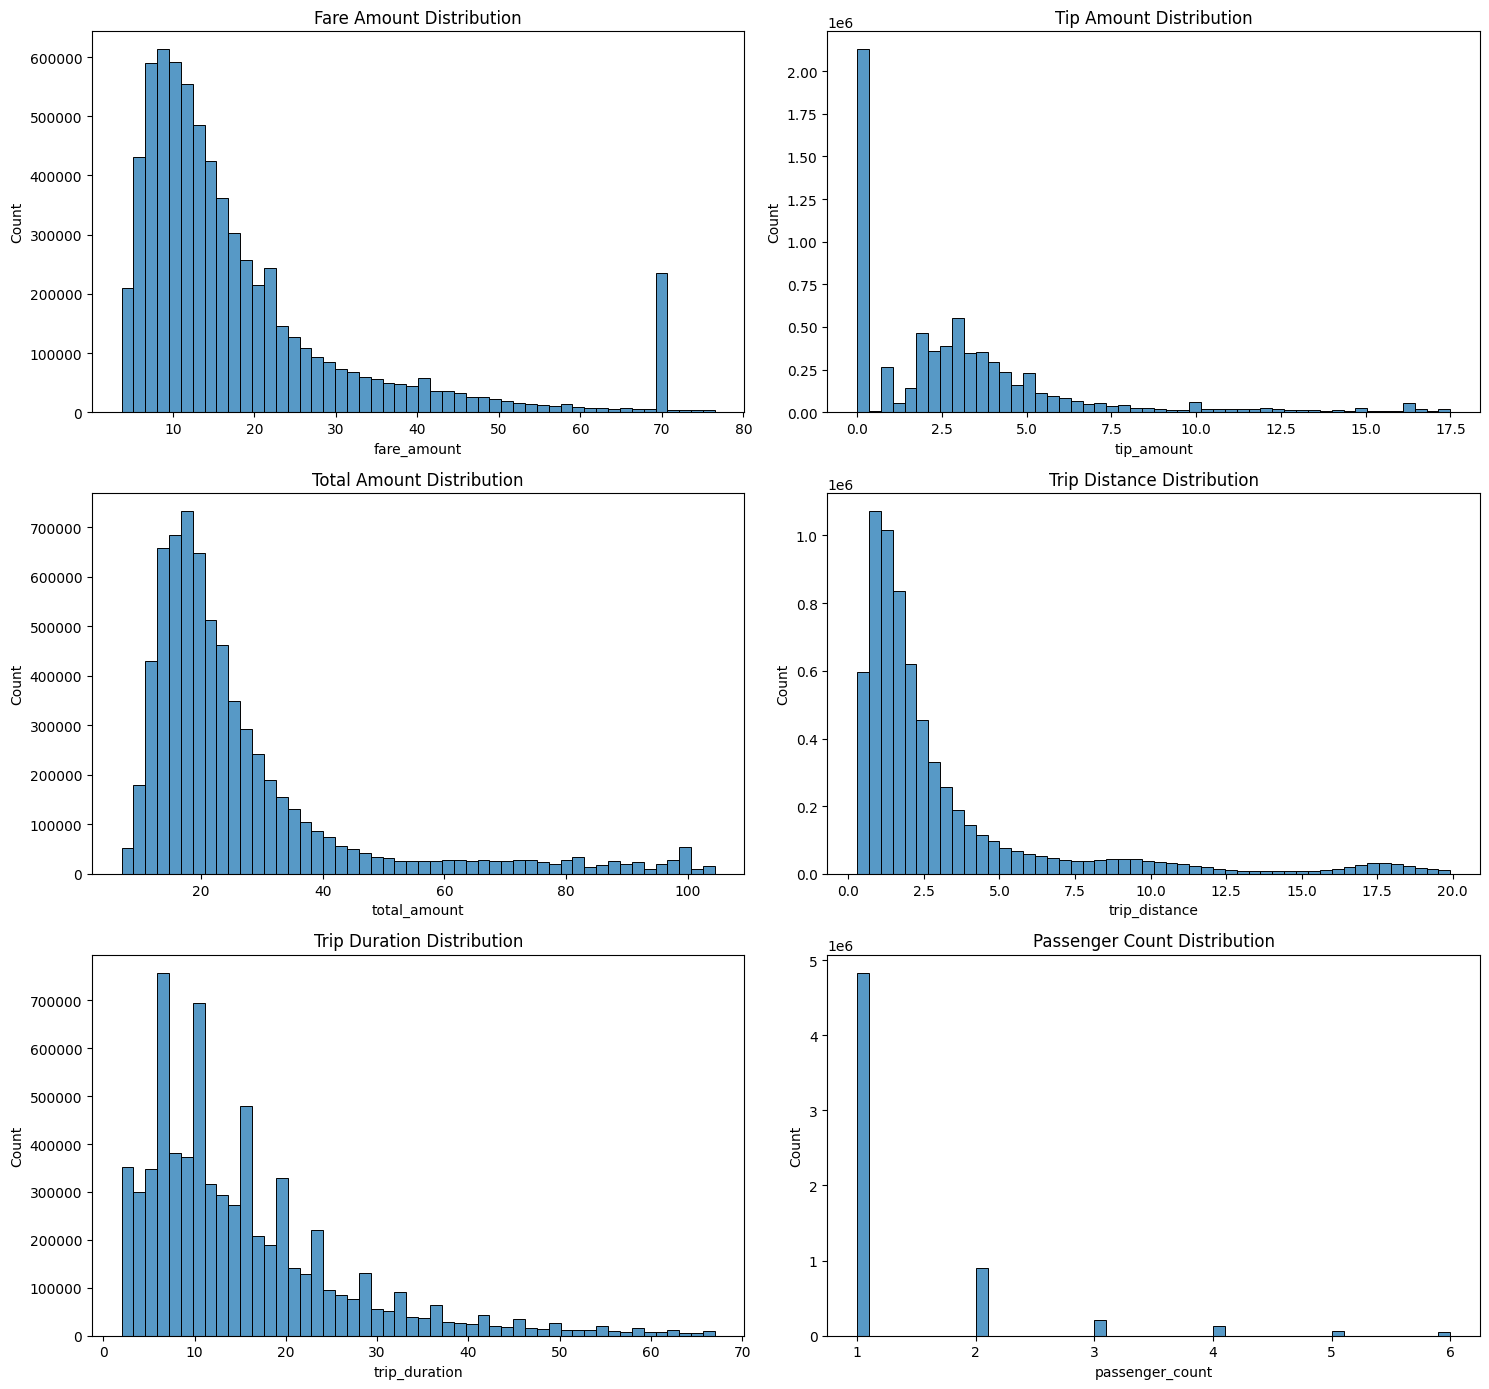


Fare Amount (after cleaning):
1st Percentile: 4.4
5th Percentile: 5.8
95th Percentile: 54.1
99th Percentile: 70.0

Tip Amount (after cleaning):
1st Percentile: 0.0
5th Percentile: 0.0
95th Percentile: 10.14
99th Percentile: 16.19

Total Amount (after cleaning):
1st Percentile: 9.1
5th Percentile: 11.5
95th Percentile: 75.55
99th Percentile: 98.88

Trip Distance (after cleaning):
1st Percentile: 0.38
5th Percentile: 0.57
95th Percentile: 11.76
99th Percentile: 18.35

Trip Duration (after cleaning):
1st Percentile: 2.0
5th Percentile: 3.0
95th Percentile: 39.0
99th Percentile: 57.0

Passenger Count (after cleaning):
1st Percentile: 1.0
5th Percentile: 1.0
95th Percentile: 3.0
99th Percentile: 5.0


In [14]:
# check outliers in fare, tip, and total amount
# Queries (no ORDER BY)
fare_outliers_query = """
SELECT fare_amount FROM nyc_taxi.taxi_weather_prejoined;
"""
tip_outliers_query = """
SELECT tip_amount FROM nyc_taxi.taxi_weather_prejoined;
"""
total_outliers_query = """
SELECT total_amount FROM nyc_taxi.taxi_weather_prejoined;
"""
trip_outliers_query = """
SELECT trip_distance FROM nyc_taxi.taxi_weather_prejoined;
"""
trip_duration_query = """
SELECT TIMESTAMPDIFF(MINUTE, tpep_pickup_datetime, tpep_dropoff_datetime) AS trip_duration
FROM nyc_taxi.taxi_weather_prejoined;
"""
passenger_count_query = """
SELECT passenger_count FROM nyc_taxi.taxi_weather_prejoined;
"""

# Load data
fare = pd.read_sql(fare_outliers_query, engine)
tip = pd.read_sql(tip_outliers_query, engine)
total = pd.read_sql(total_outliers_query, engine)
trip = pd.read_sql(trip_outliers_query, engine)
duration = pd.read_sql(trip_duration_query, engine)
passenger = pd.read_sql(passenger_count_query, engine)

# Function to clean by 1st/99th percentile
def clean_percentile(df, col, lower=0.01, upper=0.99, drop_nonpositive=True):
    if drop_nonpositive:
        df = df[df[col] > 0]
    low = df[col].quantile(lower)
    high = df[col].quantile(upper)
    return df[(df[col] >= low) & (df[col] <= high)]

# Apply adaptive cleaning
fare_clean = clean_percentile(fare, 'fare_amount')
tip_clean = clean_percentile(tip, 'tip_amount', drop_nonpositive=False)   # tips can be 0
total_clean = clean_percentile(total, 'total_amount')
trip_clean = clean_percentile(trip, 'trip_distance')
duration_clean = clean_percentile(duration, 'trip_duration')
passenger_clean = passenger[(passenger['passenger_count'] > 0) & (passenger['passenger_count'] <= 6)]
# passenger_count treated differently since it’s discrete

# Plot histograms
figs, axes = plt.subplots(3, 2, figsize=(15, 14))
sns.histplot(fare_clean['fare_amount'], bins=50, ax=axes[0, 0])
sns.histplot(tip_clean['tip_amount'], bins=50, ax=axes[0, 1])
sns.histplot(total_clean['total_amount'], bins=50, ax=axes[1, 0])
sns.histplot(trip_clean['trip_distance'], bins=50, ax=axes[1, 1])
sns.histplot(duration_clean['trip_duration'], bins=50, ax=axes[2, 0])
sns.histplot(passenger_clean['passenger_count'], bins=50, ax=axes[2, 1])
axes[0, 0].set_title('Fare Amount Distribution')
axes[0, 1].set_title('Tip Amount Distribution')
axes[1, 0].set_title('Total Amount Distribution')
axes[1, 1].set_title('Trip Distance Distribution')
axes[2, 0].set_title('Trip Duration Distribution')
axes[2, 1].set_title('Passenger Count Distribution')
plt.tight_layout()
plt.show()

# Function to print percentiles
def print_percentiles(df, col, name):
    p01 = df[col].quantile(0.01)
    p05 = df[col].quantile(0.05)
    p95 = df[col].quantile(0.95)
    p99 = df[col].quantile(0.99)
    print(f"\n{name} (after cleaning):")
    print(f"1st Percentile: {p01}")
    print(f"5th Percentile: {p05}")
    print(f"95th Percentile: {p95}")
    print(f"99th Percentile: {p99}")

# Print results
print_percentiles(fare_clean, 'fare_amount', 'Fare Amount')
print_percentiles(tip_clean, 'tip_amount', 'Tip Amount')
print_percentiles(total_clean, 'total_amount', 'Total Amount')
print_percentiles(trip_clean, 'trip_distance', 'Trip Distance')
print_percentiles(duration_clean, 'trip_duration', 'Trip Duration')
print_percentiles(passenger_clean, 'passenger_count', 'Passenger Count')







# Median queries
Use median as the distribution of my data is not normal so to better understand the typical value of our features usign the median compared to the mean will be more insightful. This is as it wont be impacted by outliers from our data. 

In [ ]:
median_condition_query = """
SELECT conditions, fare_amount, tip_amount, total_amount
FROM nyc_taxi.yellow_taxi_clean;
"""
median_day_query = """
SELECT DAYOFWEEK(tpep_pickup_datetime) AS day, fare_amount, tip_amount, total_amount
FROM nyc_taxi.yellow_taxi_clean;
"""
median_hour_query = """
SELECT HOUR(tpep_pickup_datetime) AS hour, fare_amount, tip_amount, total_amount
FROM nyc_taxi.yellow_taxi_clean;
"""
median_borough_query = """
SELECT pickup_borough, fare_amount, tip_amount, total_amount FROM nyc_taxi.yellow_taxi_clean;
"""
median_zone_query = """
SELECT pickup_zone, fare_amount, tip_amount, total_amount FROM nyc_taxi.yellow_taxi_clean;
"""
median_rainy_query = """
SELECT fare_amount, tip_amount, total_amount, CASE WHEN precip > 0 THEN 'Rainy' ELSE 'Non-rainy' END AS rain_case FROM nyc_taxi.yellow_taxi_clean;
"""
median_weekday_query = """
SELECT fare_amount, tip_amount, total_amount , CASE WHEN DAYOFWEEK(pickup_date) BETWEEN  2 and 6 THEN 'Weekday' ELSE 'Weekend' END AS day_case FROM nyc_taxi.yellow_taxi_clean;
""" 

median_condition = pd.read_sql(median_condition_query, engine)
median_day = pd.read_sql(median_day_query, engine)
median_hour = pd.read_sql(median_hour_query, engine)
median_borough = pd.read_sql(median_borough_query, engine)
median_zone = pd.read_sql(median_zone_query, engine)
median_rainy = pd.read_sql(median_rainy_query, engine)
median_weekday = pd.read_sql(median_weekday_query, engine)

# Calculate median for each subset
median_condition_f = median_condition.groupby('conditions').median().reset_index()
median_day_f = median_day.groupby('day').median().reset_index()
median_hour_f= median_hour.groupby('hour').median().reset_index()
median_borough_f = median_borough.groupby('pickup_borough').median().reset_index()
median_zone_f = median_zone.groupby('pickup_zone').median().reset_index()
median_rainy_f = median_rainy.groupby('rain_case').median().reset_index()
median_weekday_f = median_weekday.groupby('day_case').median().reset_index()











In [17]:
# Add the ride count in our median table

ride_count_zone = median_zone.groupby('pickup_zone')['fare_amount'].count().reset_index(name='ride_count')
median_zone_f = median_zone_f.merge(ride_count_zone, on='pickup_zone')

ride_count_borough = median_borough.groupby('pickup_borough')['fare_amount'].count().reset_index(name='ride_count')
median_borough_f = median_borough_f.merge(ride_count_borough, on='pickup_borough')

ride_count_weekday = median_weekday.groupby('day_case')['fare_amount'].count().reset_index(name='ride_count')
median_weekday_f = median_weekday_f.merge(ride_count_weekday, on='day_case')

ride_count_condition = median_condition.groupby('conditions')['fare_amount'].count().reset_index(name='ride_count')
median_condition_f = median_condition_f.merge(ride_count_condition, on='conditions')

ride_count_day = median_day.groupby('day')['fare_amount'].count().reset_index(name='ride_count')
median_day_f = median_day_f.merge(ride_count_day, on='day')

ride_count_hour = median_hour.groupby('hour')['fare_amount'].count().reset_index(name='ride_count')
median_hour_f = median_hour_f.merge(ride_count_hour, on='hour')

ride_count_rain = median_rainy.groupby('rain_case')['fare_amount'].count().reset_index(name='ride_count')
median_rainy_f = median_rainy_f.merge(ride_count_rain, on='rain_case')


In [10]:
# convert the median DataFrames to CSV files
median_condition_f.to_csv('median_condition_f.csv', index=False)
median_day_f.to_csv('median_day_f.csv', index=False)
median_hour_f.to_csv('median_hour_f.csv', index=False)
median_borough_f.to_csv('median_borough_f.csv', index=False)
median_zone_f.to_csv('median_zone_f.csv', index=False)
median_rainy_f.to_csv('median_rainy_f.csv', index=False)
median_weekday_f.to_csv('median_weekday_f.csv', index=False)


# Distributions
We visualized distributions to understand our data from how currency subsets are
distrbuted such as fare,tip, and total. To categorical counts such as count of rides
in certain horus or days. With weather counts and also distribution of trip duration. 
We get to see peaks of specific timeframes, patterns, and averages

/var/folders/jc/zlyx5cfj47b4kf9kgt678kkc0000gn/T/ipykernel_28633/1957330184.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[3, 0].set_xticklabels(['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'])


<Figure size 1200x1600 with 0 Axes>

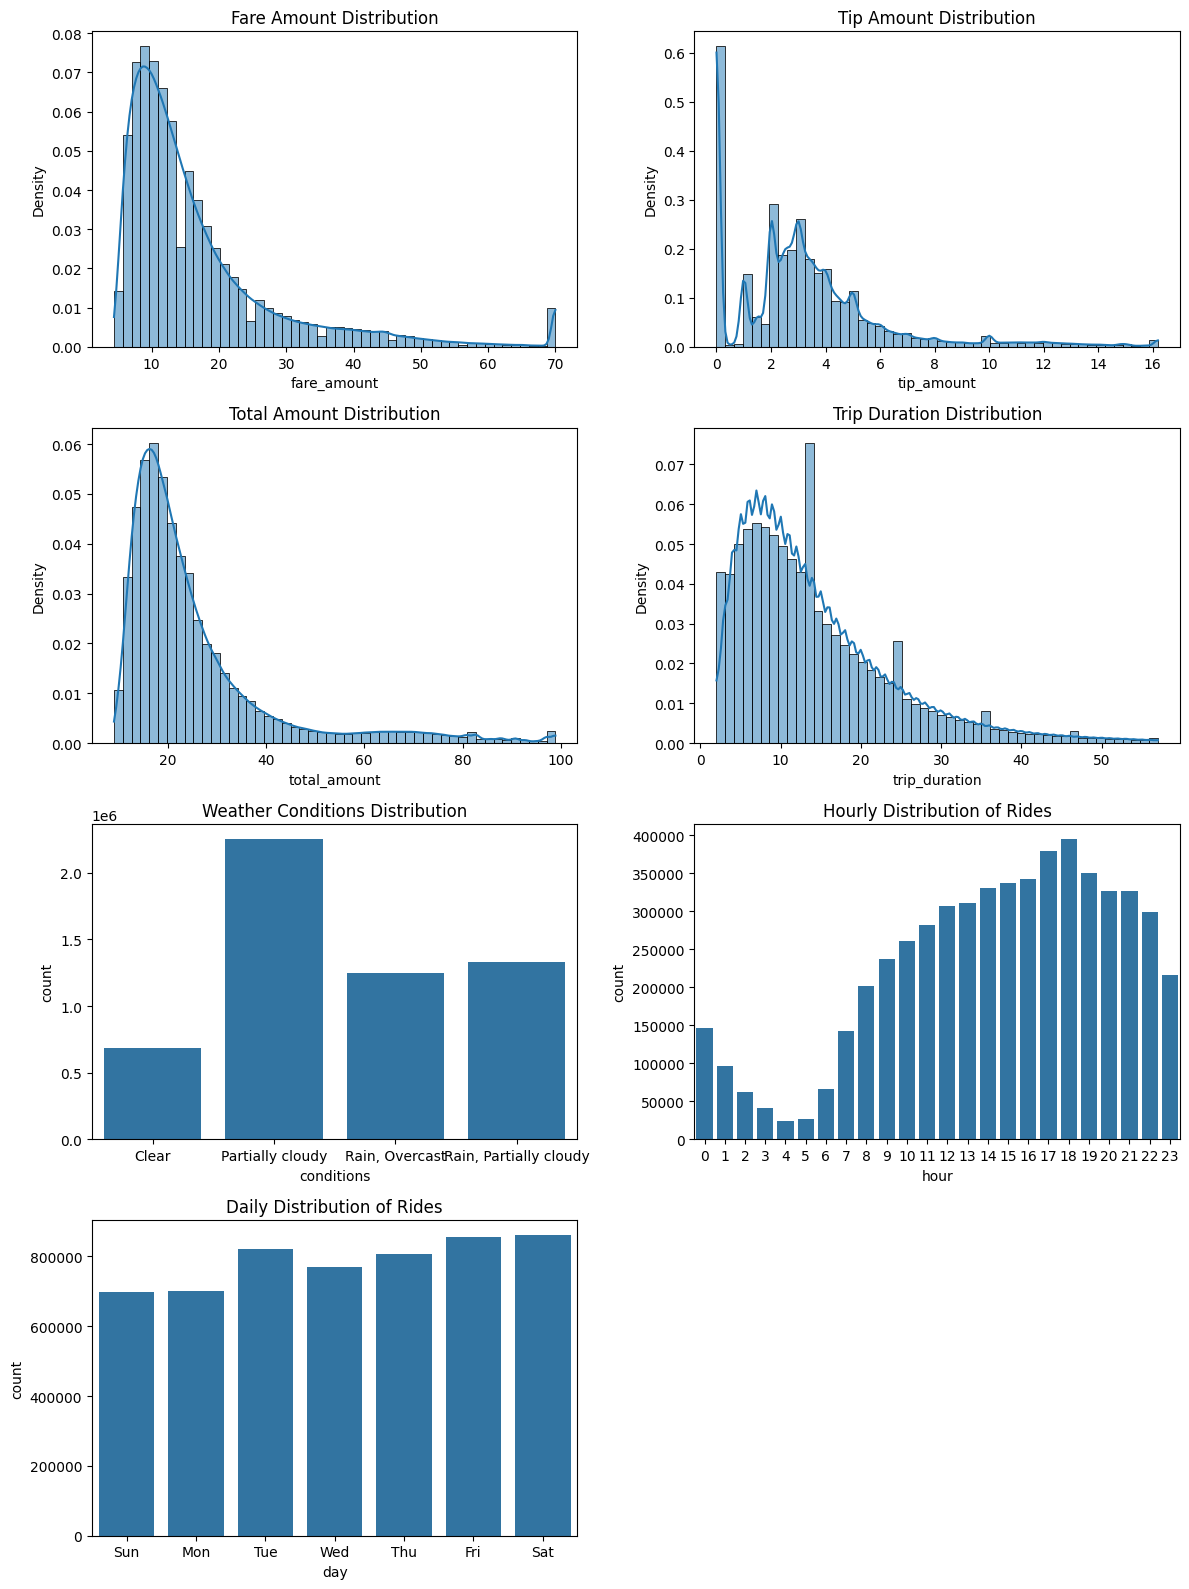

In [19]:
# distributions 
fare_distribution_query = """
SELECT fare_amount
FROM nyc_taxi.yellow_taxi_clean;
"""
tip_distribution_query = """
SELECT tip_amount
FROM nyc_taxi.yellow_taxi_clean;
"""
total_distribution_query = """
SELECT total_amount
FROM nyc_taxi.yellow_taxi_clean;
"""
trip_duration_query = """
SELECT trip_duration
FROM nyc_taxi.yellow_taxi_clean;
"""
condition_distribution_query = """
SELECT conditions, COUNT(*) AS count
FROM nyc_taxi.yellow_taxi_clean
GROUP BY conditions
ORDER BY conditions;
"""
hour_distribution_query = """
SELECT HOUR(tpep_pickup_datetime) AS hour, COUNT(*) AS count
FROM nyc_taxi.yellow_taxi_clean
GROUP BY HOUR(tpep_pickup_datetime)
ORDER BY HOUR(tpep_pickup_datetime);
"""
day_distribution_query = """
SELECT DAYOFWEEK(tpep_pickup_datetime) AS day, COUNT(*) AS count
FROM nyc_taxi.yellow_taxi_clean
GROUP BY DAYOFWEEK(tpep_pickup_datetime)
ORDER BY DAYOFWEEK(tpep_pickup_datetime);
"""

# Execute queries
fare_distribution = pd.read_sql(fare_distribution_query, engine)
tip_distribution = pd.read_sql(tip_distribution_query, engine)
total_distribution = pd.read_sql(total_distribution_query, engine)
trip_duration = pd.read_sql(trip_duration_query, engine)
condition_distribution = pd.read_sql(condition_distribution_query, engine)
hour_distribution = pd.read_sql(hour_distribution_query, engine)
day_distribution = pd.read_sql(day_distribution_query, engine)

# Visualize distributions
plt.figure(figsize=(12, 16))

fig, axs = plt.subplots(4, 2, figsize=(12, 16))
sns.histplot(fare_distribution['fare_amount'], bins=50, ax=axs[0, 0], kde=True, stat='density')
axs[0, 0].set_title('Fare Amount Distribution')
sns.histplot(tip_distribution['tip_amount'], bins=50, ax=axs[0, 1], kde=True, stat='density')
axs[0, 1].set_title('Tip Amount Distribution')
sns.histplot(total_distribution['total_amount'], bins=50, ax=axs[1, 0], kde=True, stat='density')
axs[1, 0].set_title('Total Amount Distribution')
sns.histplot(trip_duration['trip_duration'], bins=50, ax=axs[1, 1], kde=True, stat='density')
axs[1, 1].set_title('Trip Duration Distribution')
sns.barplot(x='conditions', y='count', data=condition_distribution, ax=axs[2, 0])
axs[2, 0].set_title('Weather Conditions Distribution')
sns.barplot(x='hour', y='count', data=hour_distribution, ax=axs[2, 1])
axs[2, 1].set_title('Hourly Distribution of Rides')
sns.barplot(x='day', y='count', data=day_distribution, ax=axs[3, 0])
axs[3, 0].set_title('Daily Distribution of Rides')
axs[3, 0].set_xticklabels(['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'])
axs[3, 1].axis('off')  # Empty subplot
plt.tight_layout()
plt.show()

# Top/Bottom pickup zones

We visualize the top and bottom 10 pick up zones based on factors like trip count and median fare/tip/total amount. To get a more detailed visual we
took out outliers of pickup zones with less than 100 rides as they tend to have higher averages due to few rides with high total's. However they stayed unfiltered
when visualizing trip count to see which pickup zones have the most and least trips. 

               pickup_zone  fare_amount  tip_amount  total_amount  ride_count
0  Allerton/Pelham Gardens        33.65        0.00        37.000         110
1            Alphabet City        14.20        2.86        21.360        6431
2  Arrochar/Fort Wadsworth        37.55        0.00        42.175           2
3                  Astoria        17.70        0.00        22.080        1969
4             Astoria Park        57.45        0.50        71.945          10


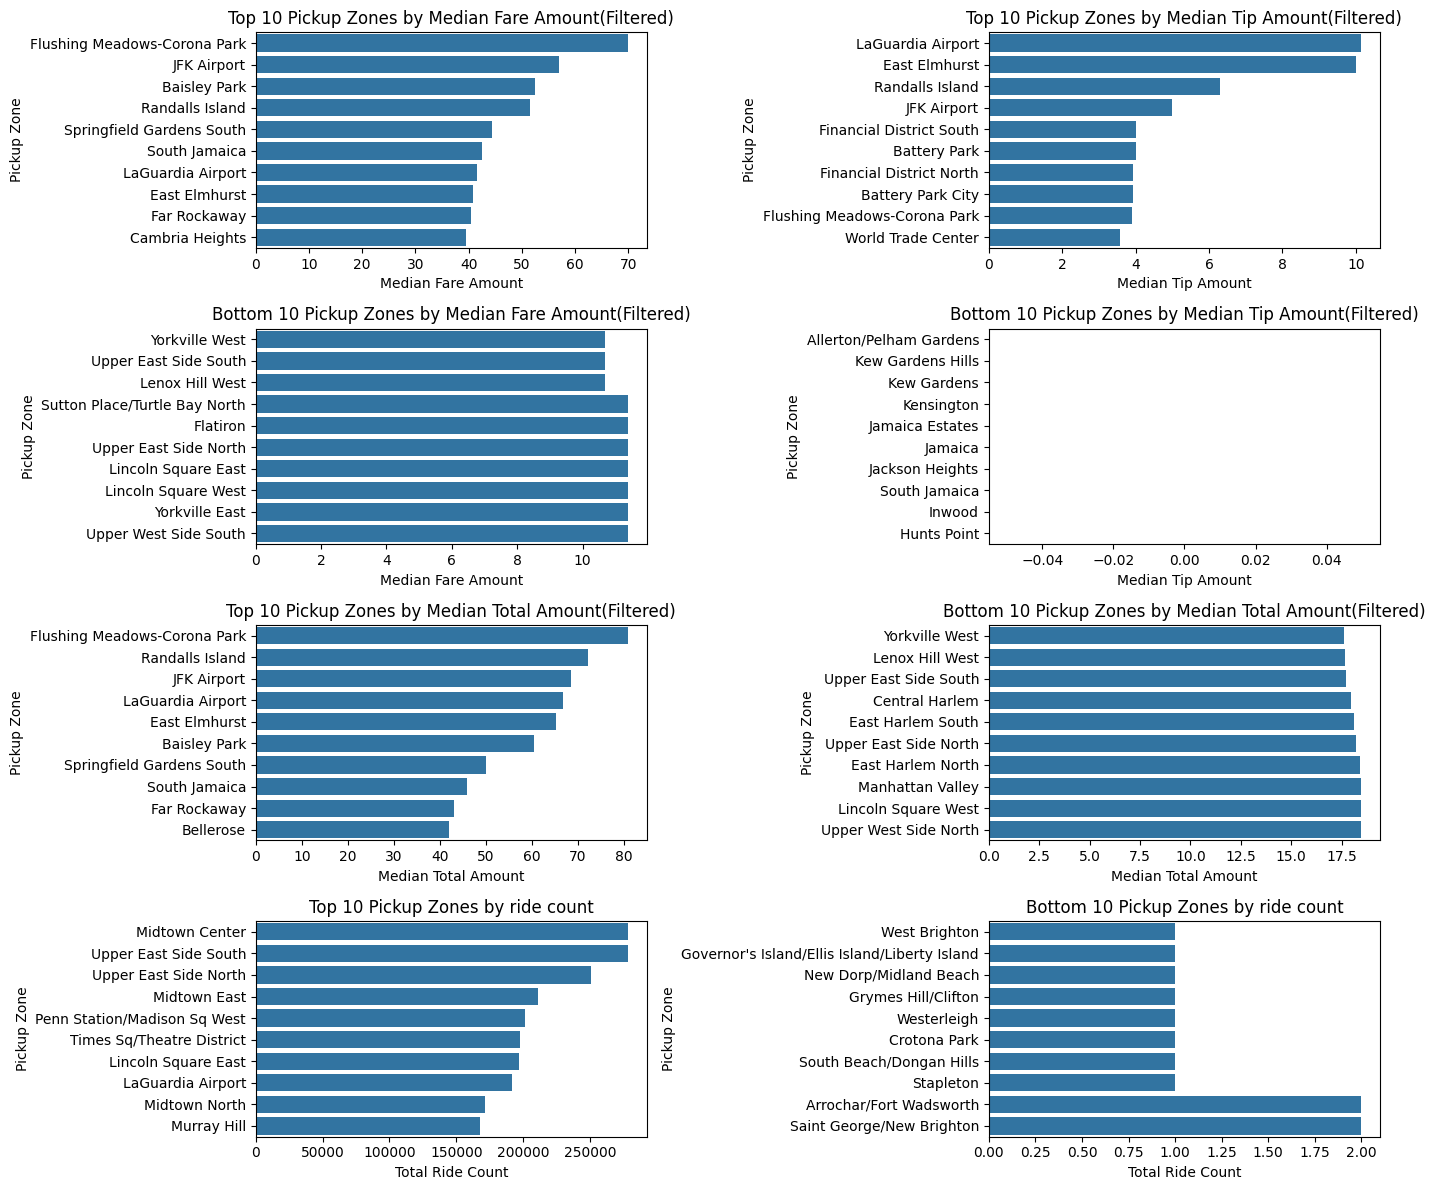

In [ ]:
figs, axes = plt.subplots(4,2, figsize = (14,12))
print(median_zone_f.head())
zone_filtered = median_zone_f[median_zone_f['ride_count'] >= 100]

# Gets the top/bottom 10 zone for each fare, tip, total, and ride count
zone_stats_top_fare = zone_filtered.sort_values(by='fare_amount', ascending=False).head(10)
zone_stats_bottom_fare = zone_filtered.sort_values(by='fare_amount', ascending=True).head(10)

zone_stats_top_tip = zone_filtered.sort_values(by='tip_amount', ascending=False).head(10)
zone_stats_bottom_tip =zone_filtered.sort_values(by='tip_amount', ascending=True).head(10)

zone_stats_top_total = zone_filtered.sort_values(by='total_amount', ascending=False).head(10)
zone_stats_bottom_total = zone_filtered.sort_values(by='total_amount', ascending=True).head(10)

zone_stats_top_count = median_zone_f.sort_values(by='ride_count', ascending = False).head(10)
zone_stats_bottom_count = median_zone_f.sort_values(by='ride_count', ascending=True).head(10)





sns.barplot(data=zone_stats_top_fare, x='fare_amount', y='pickup_zone', ax=axes[0, 0])
axes[0,0].set_xlabel('Median Fare Amount')
axes[0,0].set_ylabel('Pickup Zone')
axes[0,0].set_title('Top 10 Pickup Zones by Median Fare Amount(Filtered)')

sns.barplot(data=zone_stats_bottom_fare, x='fare_amount', y='pickup_zone', ax=axes[1, 0])
axes[1,0].set_xlabel('Median Fare Amount')
axes[1,0].set_ylabel('Pickup Zone')
axes[1,0].set_title('Bottom 10 Pickup Zones by Median Fare Amount(Filtered)')

sns.barplot(data=zone_stats_top_tip, x='tip_amount', y='pickup_zone', ax=axes[0, 1])
axes[0, 1].set_xlabel('Median Tip Amount')
axes[0, 1].set_ylabel('Pickup Zone')
axes[0, 1].set_title('Top 10 Pickup Zones by Median Tip Amount(Filtered)')

sns.barplot(data=zone_stats_bottom_tip, x='tip_amount', y='pickup_zone', ax=axes[1, 1])
axes[1, 1].set_xlabel('Median Tip Amount')
axes[1, 1].set_ylabel('Pickup Zone')
axes[1, 1].set_title('Bottom 10 Pickup Zones by Median Tip Amount(Filtered)')

sns.barplot(data=zone_stats_top_total, x='total_amount', y='pickup_zone', ax=axes[2, 0])
axes[2, 0].set_xlabel('Median Total Amount')
axes[2, 0].set_ylabel('Pickup Zone')
axes[2,0].set_title('Top 10 Pickup Zones by Median Total Amount(Filtered)')

sns.barplot(data=zone_stats_bottom_total, x='total_amount', y='pickup_zone', ax=axes[2, 1])
axes[2, 1].set_xlabel('Median Total Amount')
axes[2, 1].set_ylabel('Pickup Zone')
axes[2, 1].set_title('Bottom 10 Pickup Zones by Median Total Amount(Filtered)')

sns.barplot(data= zone_stats_top_count, x = 'ride_count', y = 'pickup_zone', ax = axes[3,0])
axes[3, 0].set_xlabel('Total Ride Count')
axes[3, 0].set_ylabel('Pickup Zone')
axes[3,0].set_title('Top 10 Pickup Zones by ride count')

sns.barplot(data= zone_stats_bottom_count, x = 'ride_count', y = 'pickup_zone', ax = axes[3,1])
axes[3, 1].set_xlabel('Total Ride Count')
axes[3, 1].set_ylabel('Pickup Zone')
axes[3,1].set_title('Bottom 10 Pickup Zones by ride count')

plt.tight_layout()
plt.show()  



In [25]:
median_zone_f.describe()

fare_amount  tip_amount  total_amount     ride_count
count   250.000000  250.000000    250.000000     250.000000
mean     25.046800    1.199440     29.710980   22058.384000
std       9.931414    2.034811     10.737171   52791.407755
min       7.900000    0.000000      9.400000       1.000000
25%      18.550000    0.000000     22.410000     118.250000
50%      24.500000    0.000000     27.350000     347.500000
75%      31.000000    2.650000     34.000000    2532.750000
max      70.000000   12.860000     80.940000  278698.000000

# Median/Total Pickup borough

We visualized the median and total fare, tip, and total amount by the 6 pick up borough's. The total amount of Queens and Manhattan overpowers the
other borough's due to its huge population compared to the other borough's. As with the median amount of the pickup borough's we need to keep in mind
that some of our boroughs such as EWR have really small count of rides which makes the median high compared to our other borough's.

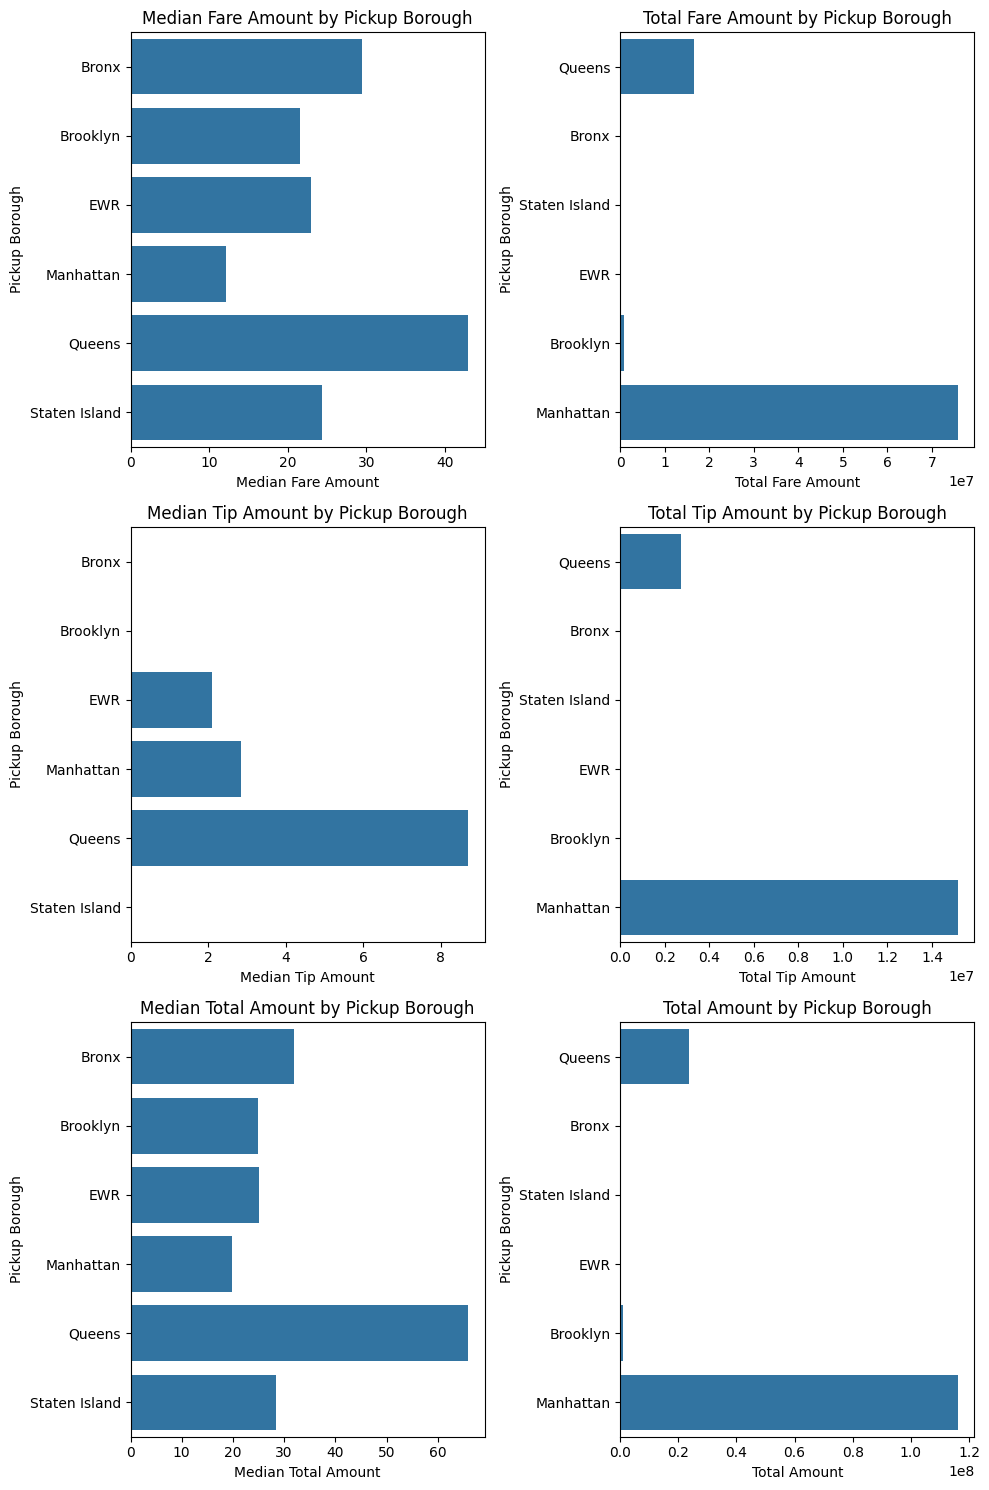

In [20]:

borough_query = """
SELECT pickup_borough, AVG(fare_amount) AS average_fare_amount, AVG(tip_amount) AS average_tip_amount, AVG(total_amount) AS average_total_amount , COUNT(fare_amount) AS trip_count, 
SUM(fare_amount) AS total_fare, SUM(tip_amount) AS total_tip, SUM(total_amount) AS total
FROM nyc_taxi.yellow_taxi_clean
GROUP BY pickup_borough
ORDER BY AVG(fare_amount) DESC;
"""
borough_stats = pd.read_sql(borough_query, engine)

fig, axes = plt.subplots(3, 2, figsize=(10, 15))
sns.barplot(data = median_borough_f, x = 'fare_amount', y = 'pickup_borough', ax = axes[0,0])
axes[0,0].set_xlabel('Median Fare Amount')
axes[0,0].set_ylabel('Pickup Borough')
axes[0,0].set_title('Median Fare Amount by Pickup Borough')


sns.barplot(data= median_borough_f, x='tip_amount', y='pickup_borough', ax=axes[1, 0])
axes[1,0].set_xlabel('Median Tip Amount')
axes[1,0].set_ylabel('Pickup Borough')
axes[1,0].set_title('Median Tip Amount by Pickup Borough')


sns.barplot(data= median_borough_f, x='total_amount', y='pickup_borough', ax=axes[2, 0])
axes[2,0].set_xlabel('Median Total Amount')
axes[2,0].set_ylabel('Pickup Borough')
axes[2,0].set_title('Median Total Amount by Pickup Borough')

sns.barplot(data=borough_stats, x='total_fare', y='pickup_borough', ax=axes[0, 1])
axes[0,1].set_xlabel('Total Fare Amount')
axes[0,1].set_ylabel('Pickup Borough')
axes[0,1].set_title('Total Fare Amount by Pickup Borough')


sns.barplot(data=borough_stats, x='total_tip', y='pickup_borough', ax=axes[1, 1])
axes[1,1].set_xlabel('Total Tip Amount')
axes[1,1].set_ylabel('Pickup Borough')
axes[1,1].set_title('Total Tip Amount by Pickup Borough')

sns.barplot(data=borough_stats, x='total', y='pickup_borough', ax=axes[2, 1])
axes[2,1].set_xlabel('Total Amount')
axes[2,1].set_ylabel('Pickup Borough')
axes[2,1].set_title('Total Amount by Pickup Borough')
plt.tight_layout()
plt.show()


# Rainy vs Non-Rainy Days

We visualize bar plots of rainy and non-rainy days ride counts, median fare, median total, and median tips. The difference of the numbers between rainy and non rainy days are little as the percentage difference is between 1-2 %. With the hourly bar graphs we also see the average totals of trips, fares, totals, and durations. Where tips are greater on average hourly for rainy days and fare is greater during non-rainy days. On average Non-rainy days make more in total than rainy days. However, more rides happen on rain days but total is less due to a smaller fare total on average compared to rainy days.
- non rainy days preform better but more rides occur during rainy days. 
- non rainy days preform better because of the higher average of fare total

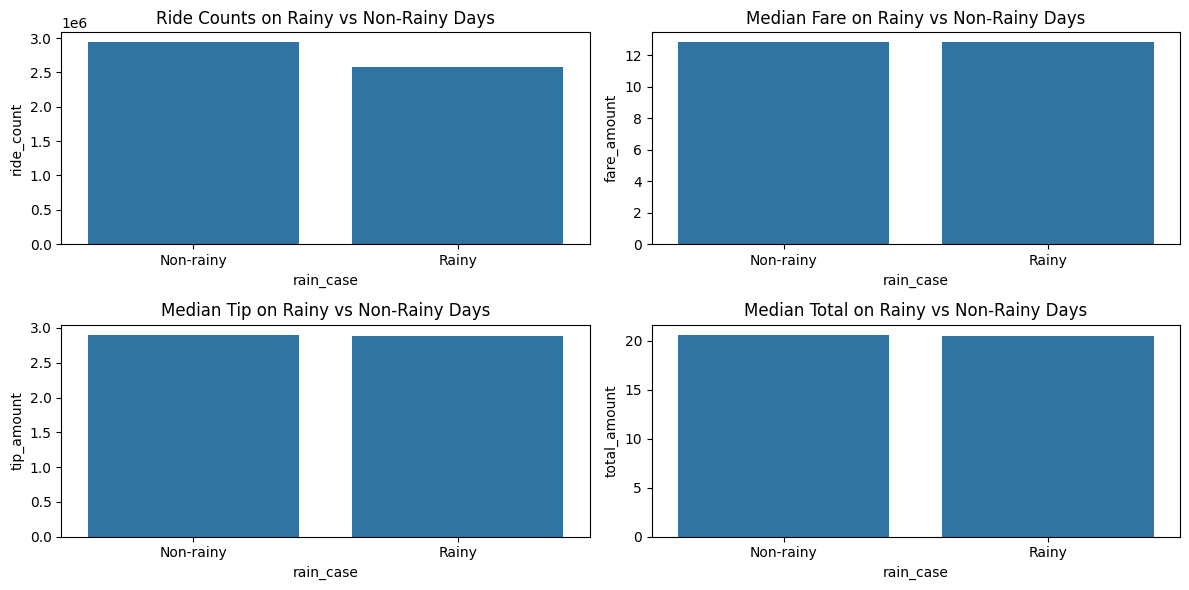

   rain_case  fare_amount  tip_amount  total_amount  ride_count
0  Non-rainy         12.8        2.90          20.6     2938090
1      Rainy         12.8        2.88          20.5     2576506


In [27]:

# Rainy vs Non-Rainy Days

figs, axes = plt.subplots(2, 2, figsize=(12, 6))
sns.barplot(data=median_rainy_f, x='rain_case', y='ride_count', ax=axes[0, 0])
axes[0,0].set_title('Ride Counts on Rainy vs Non-Rainy Days')
sns.barplot(data=median_rainy_f, x='rain_case', y='fare_amount', ax=axes[0, 1])
axes[0,1].set_title('Median Fare on Rainy vs Non-Rainy Days')
sns.barplot(data=median_rainy_f, x='rain_case', y='tip_amount', ax=axes[1, 0])
axes[1,0].set_title('Median Tip on Rainy vs Non-Rainy Days')
sns.barplot(data=median_rainy_f, x='rain_case', y='total_amount', ax=axes[1, 1])
axes[1,1].set_title('Median Total on Rainy vs Non-Rainy Days')
plt.tight_layout()
plt.show()
print(median_rainy_f)







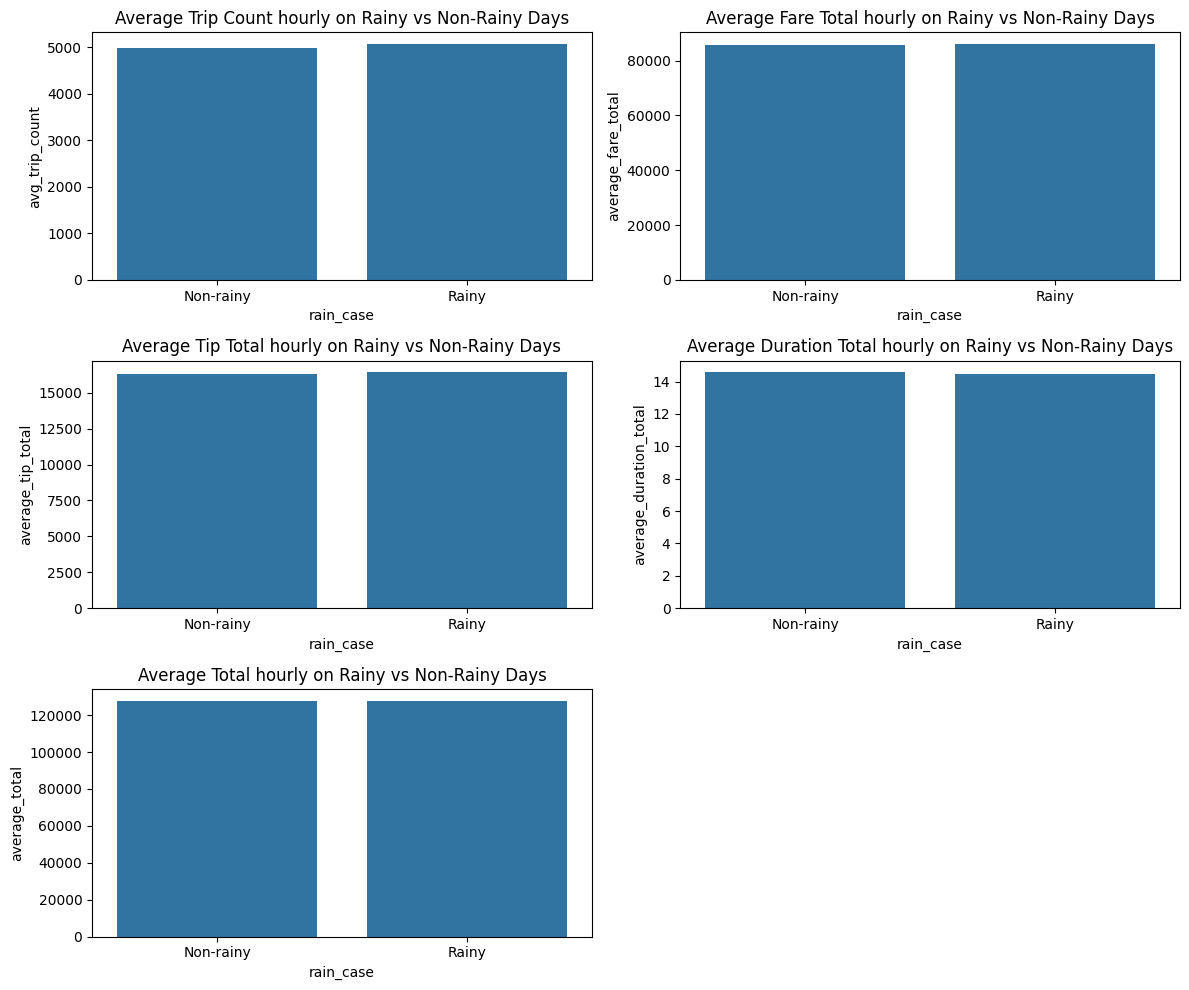

   rain_case  avg_trip_count  average_fare_total  average_tip_total  \
0  Non-rainy       4976.7172        85790.914343       16299.619192   
1      Rainy       5063.2619        85990.181071       16411.220952   

   average_duration_total  average_total  
0               14.565060  127500.598687  
1               14.454031  127763.382857  


In [21]:
rain_query_hourly = """
SELECT rain_case, AVG(count_of_rides) as avg_trip_count, AVG(Fare) AS average_fare_total, AVG(Tip) AS average_tip_total, AVG(duration) AS average_duration_total, AVG(total) AS average_total
FROM (SELECT COUNT(*) as count_of_rides, pickup_date, HOUR(tpep_pickup_datetime) as hour_taxi, SUM(fare_amount) as Fare, SUM(tip_amount) as Tip, SUM(total_amount) as total,
AVG(trip_duration) as duration, CASE WHEN precip > 0 THEN 'Rainy' ELSE 'Non-rainy' END AS rain_case FROM nyc_taxi.yellow_taxi_clean
GROUP BY pickup_date , HOUR(tpep_pickup_datetime), CASE WHEN precip > 0 THEN 'Rainy' ELSE 'Non-rainy' END) AS mini
WHERE hour_taxi IN (10,14,20)
GROUP BY rain_case;
"""
rain_stats = pd.read_sql(rain_query_hourly, engine)

figs, axes = plt.subplots(3, 2, figsize=(12, 10))
sns.barplot(data=rain_stats, x='rain_case', y='avg_trip_count', ax=axes[0, 0])
axes[0, 0].set_title('Average Trip Count hourly on Rainy vs Non-Rainy Days')
sns.barplot(data=rain_stats, x='rain_case', y='average_fare_total', ax=axes[0, 1])
axes[0, 1].set_title('Average Fare Total hourly on Rainy vs Non-Rainy Days')
sns.barplot(data=rain_stats, x='rain_case', y='average_tip_total', ax=axes[1, 0])
axes[1, 0].set_title('Average Tip Total hourly on Rainy vs Non-Rainy Days')
sns.barplot(data=rain_stats, x='rain_case', y='average_duration_total', ax=axes[1, 1])
axes[1, 1].set_title('Average Duration Total hourly on Rainy vs Non-Rainy Days')
sns.barplot(data=rain_stats, x='rain_case', y='average_total', ax=axes[2, 0])
axes[2, 0].set_title('Average Total hourly on Rainy vs Non-Rainy Days')
axes[2, 1].axis('off')  # Empty subplot
plt.tight_layout()
plt.show()
print(rain_stats)

# Trip Duration 
Made a line graph of trip duration vs average fare/tip/total amount and it shows as duration increase our average amount of all types also increases but towards the end the slope slowly increases comapred to the beginning. Kept average as it will have the same pattern as with using the median because fare, tip, and total will increase as trip duration. 

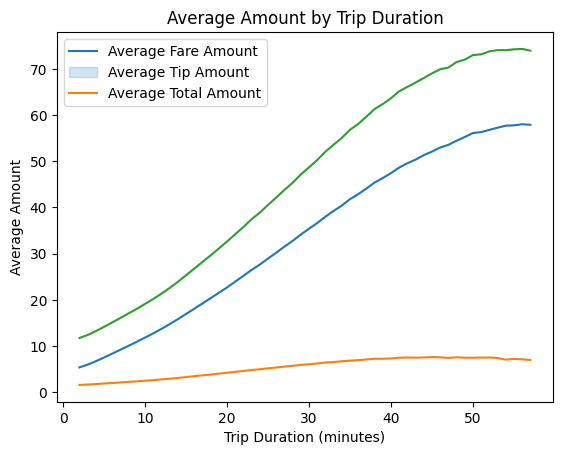

In [22]:

# Trip Duration vs Average Fare Amount
trip_query = """
SELECT Trip_duration, AVG(fare_amount) AS average_fare_amount, AVG(tip_amount) AS average_tip_amount, AVG(total_amount) AS average_total_amount FROM nyc_taxi.yellow_taxi_clean
GROUP BY Trip_duration
ORDER BY Trip_duration;
"""
trip_duration_fare = pd.read_sql(trip_query, engine)
trip_duration_fare = trip_duration_fare.sort_values(by='Trip_duration')
sns.lineplot(data=trip_duration_fare, x='Trip_duration', y='average_fare_amount')
sns.lineplot(data=trip_duration_fare, x='Trip_duration', y='average_tip_amount')
sns.lineplot(data=trip_duration_fare, x='Trip_duration', y='average_total_amount')
plt.title('Average Amount by Trip Duration')
plt.xlabel('Trip Duration (minutes)')
plt.legend(['Average Fare Amount', 'Average Tip Amount', 'Average Total Amount'])
plt.ylabel('Average Amount')
plt.show()


## weekday vs weekend

# Per Ride
Percent difference between average fare/tips/totals is between 1-5%. Tip and total is 2-5% greater on average per rides during the weekdays and fare is 0.1% greater on average during the weekends. Where as for medians it mostly stayed the same between weekdays or weekend. 

# Per borough/hour

Bar chart with weekdays having more rides on average per hour. Where our tip, total, fare, and count of rides all shows a higher average total hourly during weekdays compared to weekends.

- Main difference between both was due to the amount of ride counts on weekdays compared to weekends
- Hourly stats during weekdays are higher due to make rides hourly during the weekdays compared to weekends


In [31]:
#weekday vs week per ride 

print(median_weekday_f)

  day_case  fare_amount  tip_amount  total_amount  ride_count
0  Weekday         12.8        2.95         20.80     3955708
1  Weekend         12.8        2.72         19.68     1558888


  pickup_borough  weekday_total_count  weekend_total_count  \
0          Bronx               5841.0               2029.0   
1       Brooklyn              27124.0               8517.0   
2            EWR                  6.0                  4.0   
3      Manhattan            3653389.0            1442388.0   
4         Queens             269342.0             105942.0   
5  Staten Island                  6.0                  8.0   

   avg_weekday_ride_count  avg_weekend_ride_count  avg_hourly_fare_Weekday  \
0                  6.9124                  5.4838               213.354189   
1                 26.9622                 19.7610               655.091093   
2                  1.0000                  1.0000                24.133333   
3               3540.1056               3346.6079             52669.263450   
4                260.9903                245.8051             11463.121395   
5                  1.0000                  1.0000                17.350000   

   avg_hourly_fare

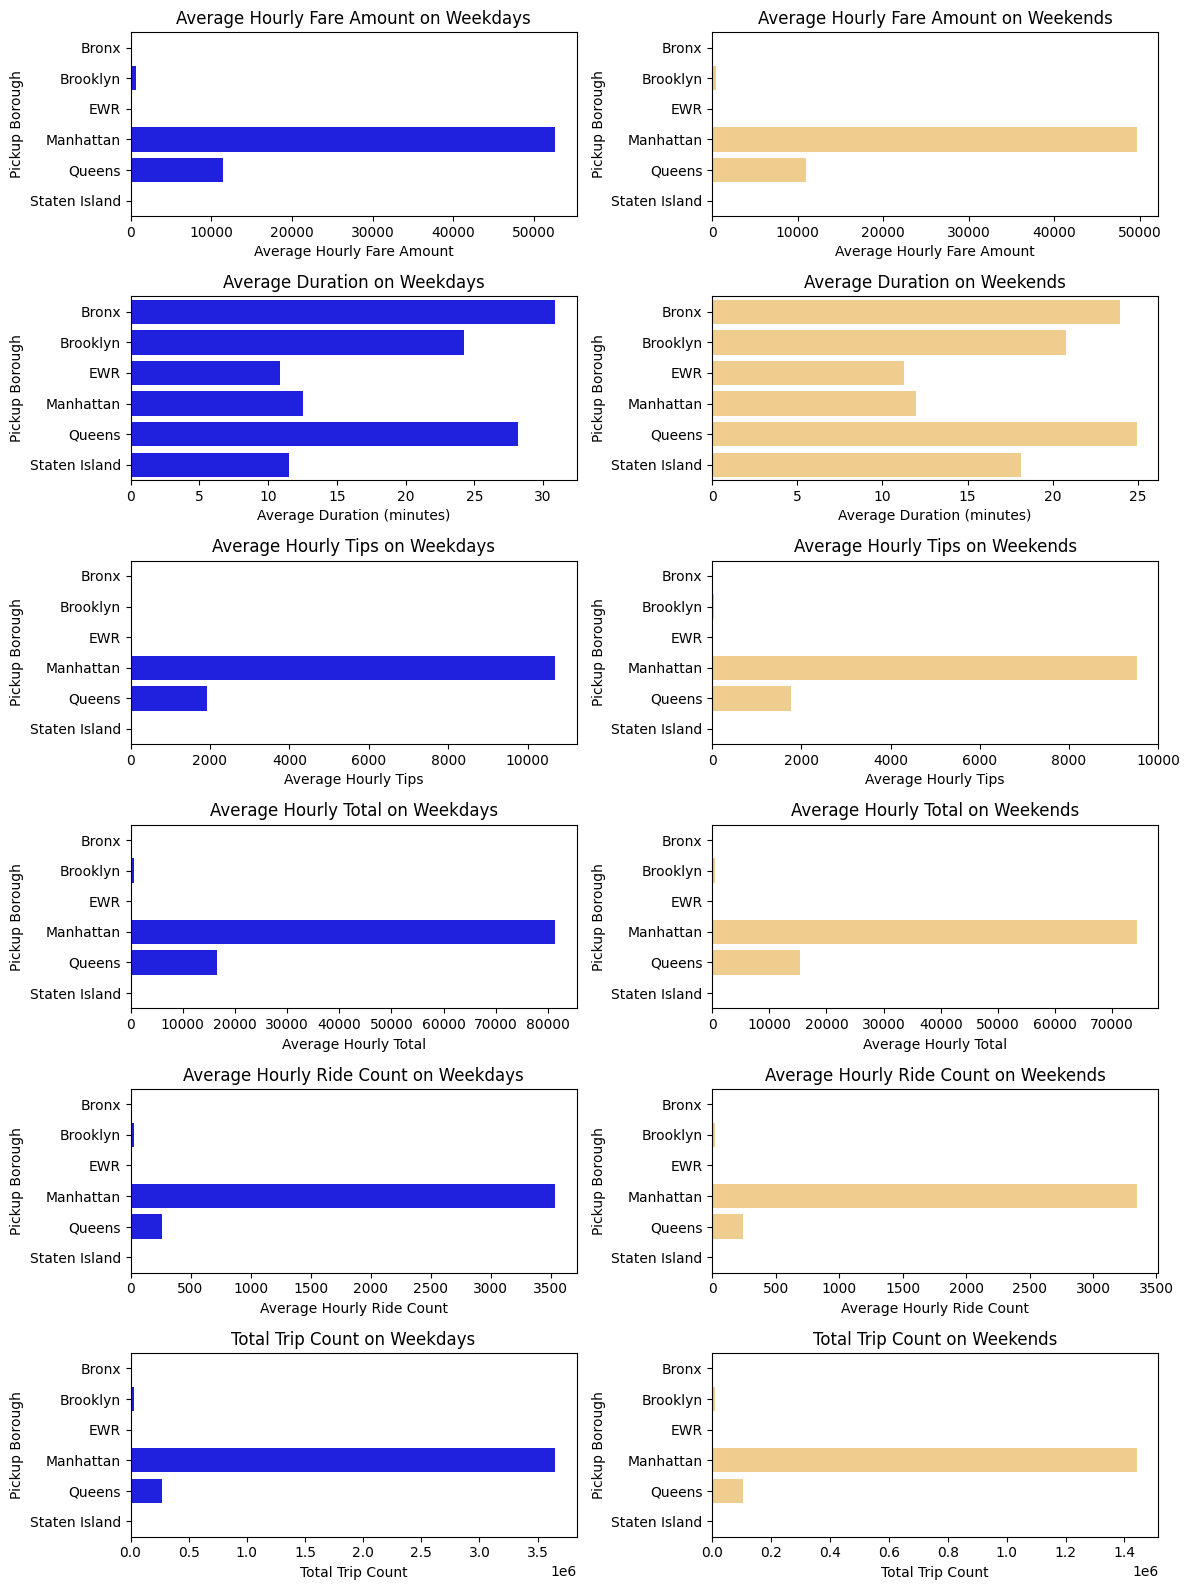

   avg_hourly_fare_Weekday  avg_hourly_fare_Weekend  avg_hourly_tips_Weekday  \
0               213.354189               148.871081                 1.626544   
1               655.091093               474.345290                33.591093   
2                24.133333                27.525000                 2.015000   
3             52669.263450             49666.099606             10697.177171   
4             11463.121395             10952.209026              1917.073857   
5                17.350000                32.175000                 1.865000   

   avg_hourly_tips_Weekend  avg_hourly_total_Weekday  avg_hourly_total_Weekend  
0                 1.627595                237.278154                164.628892  
1                47.761531                759.633569                582.040464  
2                 5.410000                 28.648333                 38.280000  
3              9527.458747              81418.383711              74339.043411  
4              1775.895058        

In [24]:
#weekday vs weekend by zone/date/hour
week_query = """
SELECT 
  pickup_borough,
  
  -- Total trip counts (now counting date/zone/hour combinations)
  SUM(CASE WHEN DAYOFWEEK(pickup_date) BETWEEN 2 AND 6 THEN total_rides END) AS weekday_total_count,
  SUM(CASE WHEN DAYOFWEEK(pickup_date) NOT BETWEEN 2 AND 6 THEN total_rides END) AS weekend_total_count,
  
  -- Combinations by day type
  AVG(CASE WHEN DAYOFWEEK(pickup_date) BETWEEN 2 AND 6 THEN total_rides END) AS avg_weekday_ride_count,
  AVG(CASE WHEN DAYOFWEEK(pickup_date) NOT BETWEEN 2 AND 6 THEN total_rides END) AS avg_weekend_ride_count,
  
  -- Average of summed fare amounts (average daily/hourly fare totals)
  AVG(CASE WHEN DAYOFWEEK(pickup_date) BETWEEN 2 AND 6 THEN total_fare END) AS avg_hourly_fare_Weekday,
  AVG(CASE WHEN DAYOFWEEK(pickup_date) NOT BETWEEN 2 AND 6 THEN total_fare END) AS avg_hourly_fare_Weekend,
  
  -- Average of averaged trip durations
  AVG(CASE WHEN DAYOFWEEK(pickup_date) BETWEEN 2 AND 6 THEN avg_duration END) AS avg_duration_Weekday,
  AVG(CASE WHEN DAYOFWEEK(pickup_date) NOT BETWEEN 2 AND 6 THEN avg_duration END) AS avg_duration_Weekend,
  
  -- Average of summed tip amounts
  AVG(CASE WHEN DAYOFWEEK(pickup_date) BETWEEN 2 AND 6 THEN total_tips END) AS avg_hourly_tips_Weekday,
  AVG(CASE WHEN DAYOFWEEK(pickup_date) NOT BETWEEN 2 AND 6 THEN total_tips END) AS avg_hourly_tips_Weekend,
  
  -- Average of summed total amounts
  AVG(CASE WHEN DAYOFWEEK(pickup_date) BETWEEN 2 AND 6 THEN total_amount_sum END) AS avg_hourly_total_Weekday,
  AVG(CASE WHEN DAYOFWEEK(pickup_date) NOT BETWEEN 2 AND 6 THEN total_amount_sum END) AS avg_hourly_total_Weekend

FROM (
  SELECT 
    pickup_date, 
    pickup_borough, 
    COUNT(*) AS total_rides,
    SUM(fare_amount) AS total_fare,
    AVG(trip_duration) AS avg_duration,
    SUM(tip_amount) AS total_tips,
    SUM(total_amount) AS total_amount_sum,
    HOUR(tpep_pickup_datetime) AS hour_taxi,
    CASE WHEN DAYOFWEEK(pickup_date) BETWEEN 2 AND 6 THEN 'Weekday' ELSE 'Weekend' END AS day_type
  FROM nyc_taxi.yellow_taxi_clean
  GROUP BY pickup_date, pickup_borough, HOUR(tpep_pickup_datetime), 
           CASE WHEN DAYOFWEEK(pickup_date) BETWEEN 2 AND 6 THEN 'Weekday' ELSE 'Weekend' END
) AS subquery
GROUP BY pickup_borough
ORDER BY pickup_borough;
"""
weekday_weekend_counts = pd.read_sql(week_query, engine)
print(weekday_weekend_counts)
figs, axes = plt.subplots(6, 2, figsize=(12, 16))

sns.barplot(data=weekday_weekend_counts, x='avg_hourly_fare_Weekday', y='pickup_borough', color='blue', ax=axes[0, 0])
sns.barplot(data=weekday_weekend_counts, x='avg_hourly_fare_Weekend', y='pickup_borough', color='orange', alpha=0.5, ax=axes[0, 1])
axes[0, 0].set_title('Average Hourly Fare Amount on Weekdays')
axes[0, 1].set_title('Average Hourly Fare Amount on Weekends')
axes[0, 0].set_xlabel('Average Hourly Fare Amount')
axes[0, 1].set_xlabel('Average Hourly Fare Amount')
axes[0, 0].set_ylabel('Pickup Borough')
axes[0, 1].set_ylabel('Pickup Borough')

sns.barplot(data=weekday_weekend_counts, x='avg_duration_Weekday', y='pickup_borough', color='blue', ax=axes[1, 0])
sns.barplot(data=weekday_weekend_counts, x='avg_duration_Weekend', y='pickup_borough', color='orange', alpha=0.5, ax=axes[1, 1])
axes[1, 0].set_title('Average Duration on Weekdays')
axes[1, 1].set_title('Average Duration on Weekends')
axes[1, 0].set_xlabel('Average Duration (minutes)')
axes[1, 1].set_xlabel('Average Duration (minutes)')
axes[1, 0].set_ylabel('Pickup Borough')
axes[1, 1].set_ylabel('Pickup Borough')   

sns.barplot(data=weekday_weekend_counts, x='avg_hourly_tips_Weekday', y='pickup_borough', color='blue', ax=axes[2, 0])
sns.barplot(data=weekday_weekend_counts, x='avg_hourly_tips_Weekend', y='pickup_borough', color='orange', alpha=0.5, ax=axes[2, 1])
axes[2, 0].set_title('Average Hourly Tips on Weekdays')
axes[2, 1].set_title('Average Hourly Tips on Weekends')
axes[2, 0].set_xlabel('Average Hourly Tips')
axes[2, 1].set_xlabel('Average Hourly Tips')
axes[2, 0].set_ylabel('Pickup Borough')
axes[2, 1].set_ylabel('Pickup Borough')

sns.barplot(data=weekday_weekend_counts, x='avg_hourly_total_Weekday', y='pickup_borough', color='blue', ax=axes[3, 0])
sns.barplot(data=weekday_weekend_counts, x='avg_hourly_total_Weekend', y='pickup_borough', color='orange', alpha=0.5, ax=axes[3, 1])
axes[3, 0].set_title('Average Hourly Total on Weekdays')
axes[3, 1].set_title('Average Hourly Total on Weekends')
axes[3, 0].set_xlabel('Average Hourly Total')
axes[3, 1].set_xlabel('Average Hourly Total')
axes[3, 0].set_ylabel('Pickup Borough')
axes[3, 1].set_ylabel('Pickup Borough')

sns.barplot(data=weekday_weekend_counts, x='avg_weekday_ride_count', y='pickup_borough', color='blue', ax=axes[4, 0])
sns.barplot(data=weekday_weekend_counts, x='avg_weekend_ride_count', y='pickup_borough', color='orange', alpha=0.5, ax=axes[4, 1])
axes[4, 0].set_title('Average Hourly Ride Count on Weekdays')
axes[4, 1].set_title('Average Hourly Ride Count on Weekends')  
axes[4, 0].set_xlabel('Average Hourly Ride Count')
axes[4, 1].set_xlabel('Average Hourly Ride Count')
axes[4, 0].set_ylabel('Pickup Borough')
axes[4, 1].set_ylabel('Pickup Borough')

sns.barplot(data=weekday_weekend_counts, x='weekday_total_count', y='pickup_borough', color='blue', ax=axes[5, 0])
axes[5, 0].set_title('Total Trip Count on Weekdays')
sns.barplot(data=weekday_weekend_counts, x='weekend_total_count', y='pickup_borough', color='orange', alpha=0.5, ax=axes[5, 1])
axes[5, 1].set_title('Total Trip Count on Weekends')
axes[5, 0].set_xlabel('Total Trip Count')
axes[5, 1].set_xlabel('Total Trip Count')
axes[5, 0].set_ylabel('Pickup Borough')
axes[5, 1].set_ylabel('Pickup Borough')

plt.tight_layout()
plt.show()  

print(weekday_weekend_counts[['avg_hourly_fare_Weekday', 'avg_hourly_fare_Weekend', 'avg_hourly_tips_Weekday', 'avg_hourly_tips_Weekend', 'avg_hourly_total_Weekday', 'avg_hourly_total_Weekend']])


# Hour vs AVG fare/tip/total and Total Ride count

We visualize using barplot and line plot to see how the hour of day impact either Median of fare/tip/total or total ride count throughout the day. 
Also, we look at hourly stats such as average fare/tip/total for each hour to see the patterns and how ot it changes within the hours of the day
This reveals peaks and patterns of specific hours during the day. Can be used to see times where surges can occur, patterns, and peaks/lows to better schedule and planning.

-Average hourly shows similar patterns between all metrics of a decrease in the beginning and then a increase throughout the afternoon until it starts decreasing by 5-6pm

- Median average per ride shows same pattern but less sensitive within tips but with fare and total there is a increase in the median of fare/total between 4am and 5am

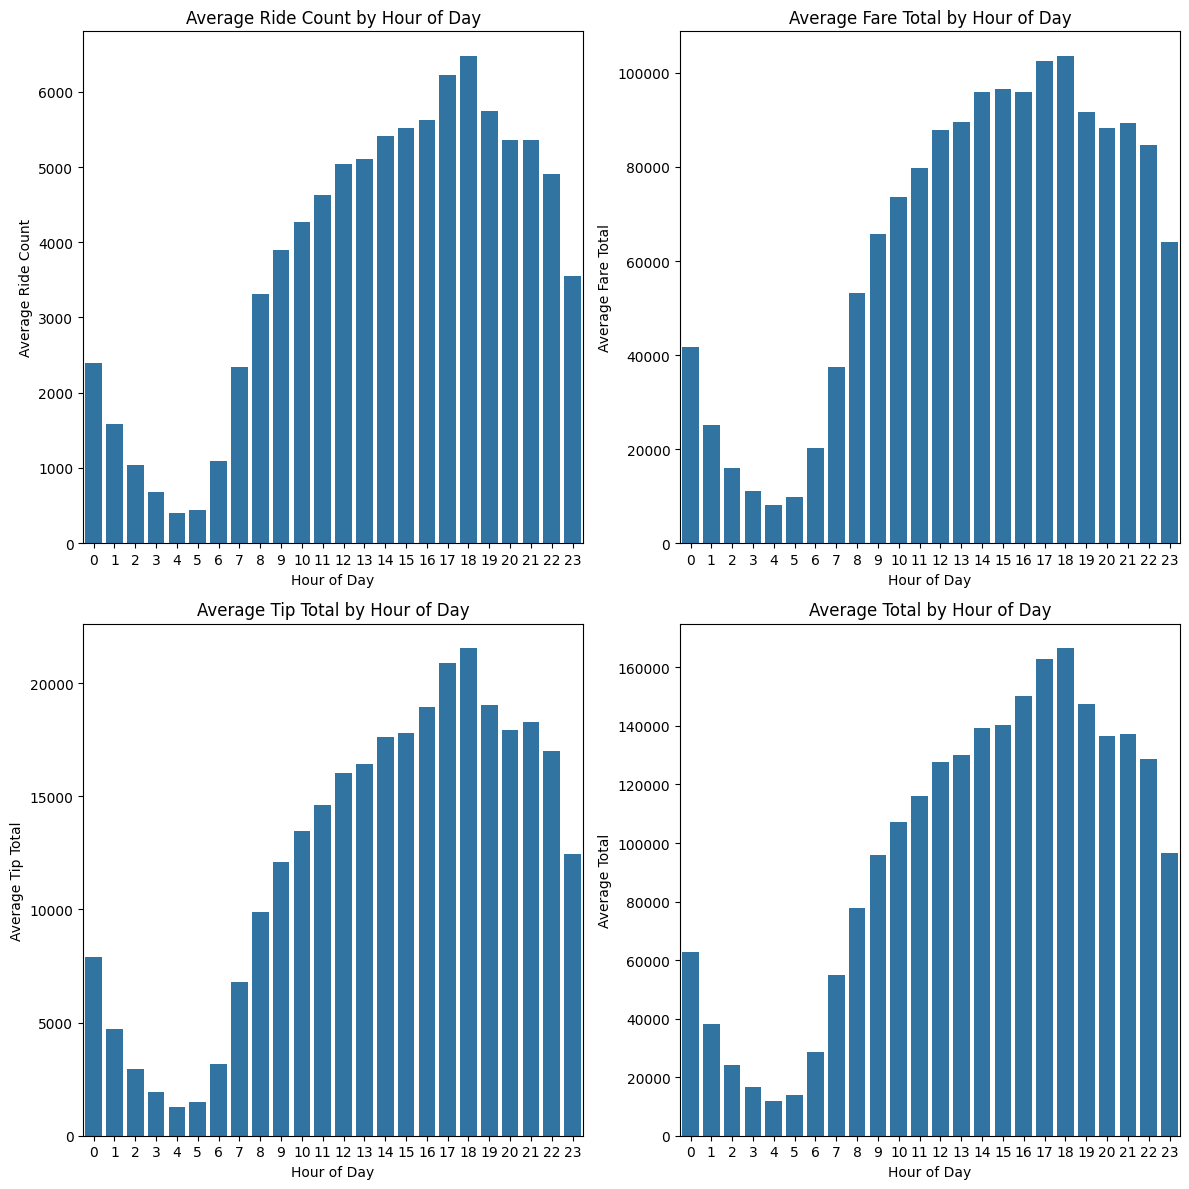

In [25]:

#hour of day vs total averages

h_query = """
SELECT hour_per_day, AVG(ride_count) AS ride_count_hourly, AVG(fare_total) AS avg_fare_total_hourly, AVG(tip_total) AS avg_tip_total_hourly, AVG(total) AS avg_total_hourly FROM
(SELECT pickup_date, HOUR(tpep_pickup_datetime) AS hour_per_day, COUNT(*) AS ride_count, SUM(fare_amount) as fare_total, SUM(tip_amount) as tip_total, SUM(total_amount) as total
FROM nyc_taxi.yellow_taxi_clean GROUP BY pickup_date ,HOUR(tpep_pickup_datetime)) as day
GROUP BY hour_per_day;
"""
hourly_stats = pd.read_sql(h_query, engine)
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

sns.barplot(data=hourly_stats, x='hour_per_day', y='ride_count_hourly', ax=axes[0, 0])
axes[0, 0].set_title('Average Ride Count by Hour of Day')
sns.barplot(data=hourly_stats, x='hour_per_day', y='avg_fare_total_hourly', ax=axes[0, 1])
axes[0, 1].set_title('Average Fare Total by Hour of Day')
sns.barplot(data=hourly_stats, x='hour_per_day', y='avg_tip_total_hourly', ax=axes[1, 0])
axes[1, 0].set_title('Average Tip Total by Hour of Day')
sns.barplot(data=hourly_stats, x='hour_per_day', y='avg_total_hourly', ax=axes[1, 1])
axes[1, 1].set_title('Average Total by Hour of Day')


axes[0, 0].set_xlabel('Hour of Day')
axes[0, 1].set_xlabel('Hour of Day')
axes[1, 0].set_xlabel('Hour of Day')
axes[1, 1].set_xlabel('Hour of Day')
axes[0, 0].set_ylabel('Average Ride Count')
axes[0, 1].set_ylabel('Average Fare Total')
axes[1, 0].set_ylabel('Average Tip Total')
axes[1, 1].set_ylabel('Average Total')  

plt.tight_layout()
plt.show()

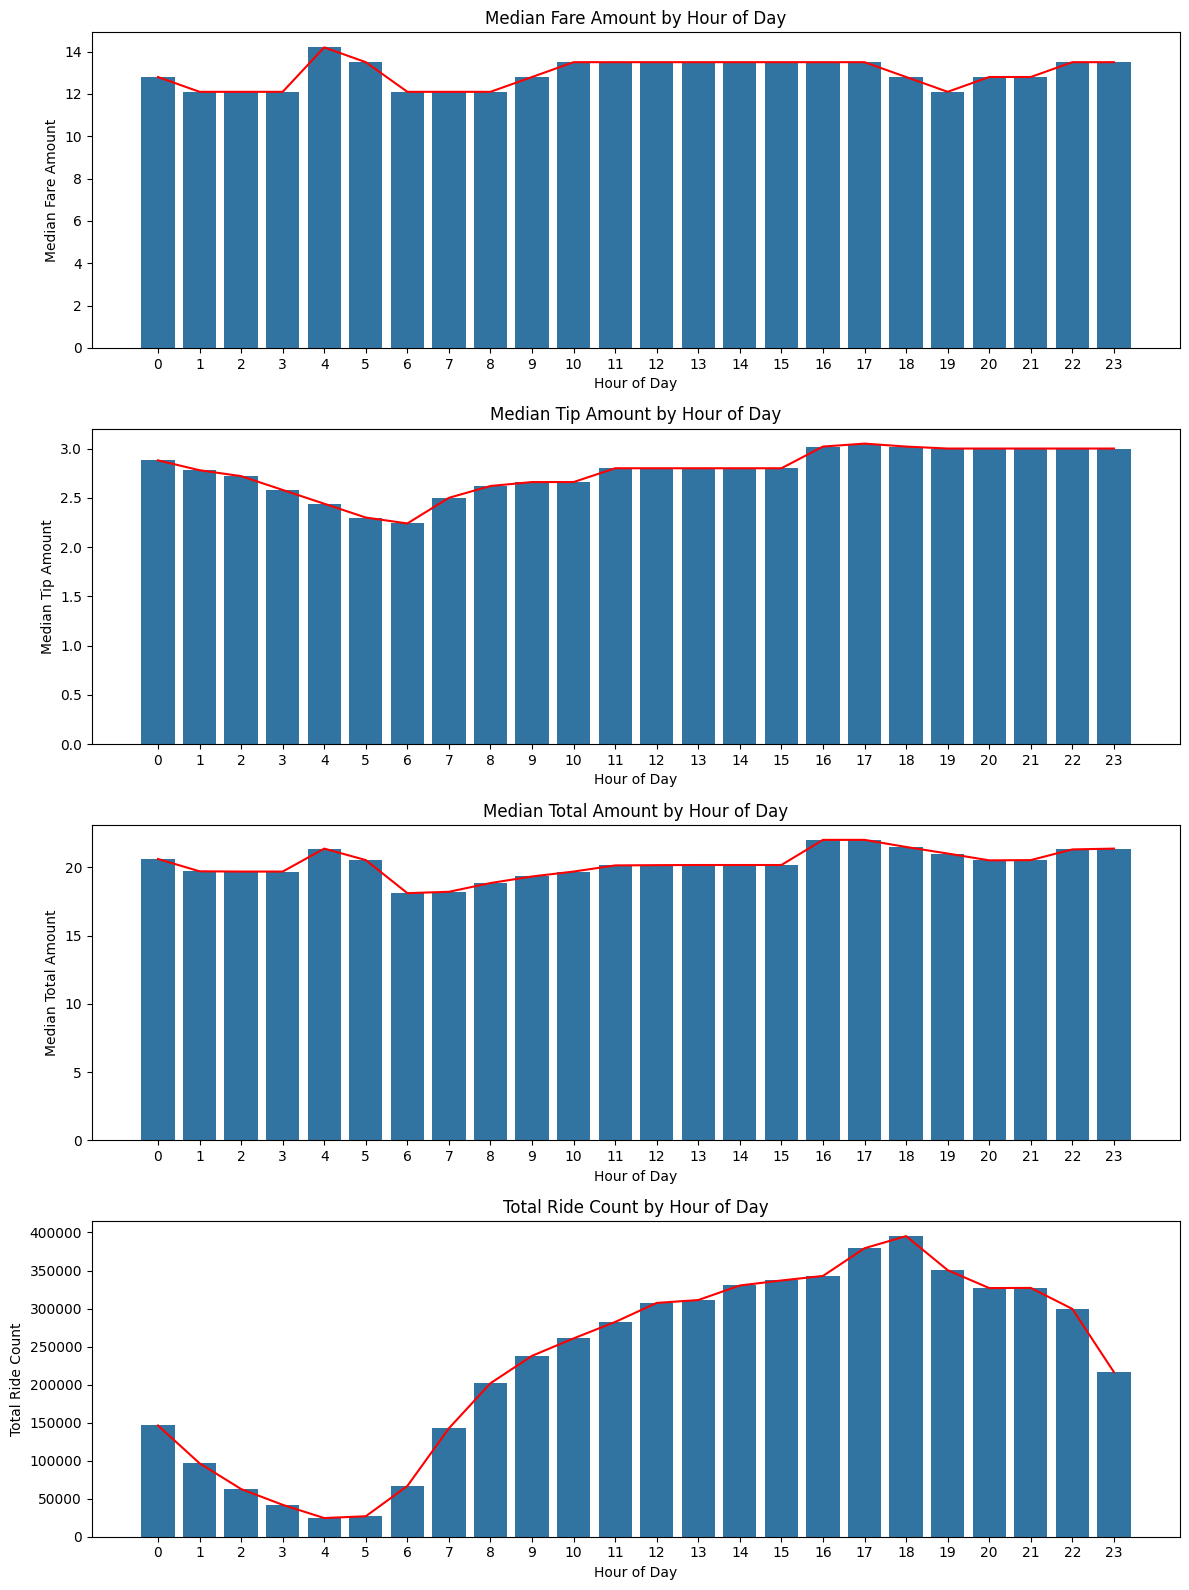

In [35]:

# hour of day vs median fare amount
fig, axes = plt.subplots(4, 1, figsize=(12, 16))

sns.barplot(data=median_hour_f, x='hour', y='fare_amount', ax=axes[0])
sns.lineplot(data=median_hour_f, x='hour', y='fare_amount', ax=axes[0], color='red')
axes[0].set_xlabel('Hour of Day')
axes[0].set_ylabel('Median Fare Amount')
axes[0].set_title('Median Fare Amount by Hour of Day')

sns.barplot(data=median_hour_f, x='hour', y='tip_amount', ax=axes[1])
sns.lineplot(data=median_hour_f, x='hour', y='tip_amount', ax=axes[1], color='red')
axes[1].set_xlabel('Hour of Day')
axes[1].set_ylabel('Median Tip Amount')
axes[1].set_title('Median Tip Amount by Hour of Day')

sns.barplot(data=median_hour_f, x='hour', y='total_amount', ax=axes[2])
sns.lineplot(data=median_hour_f, x='hour', y='total_amount', ax=axes[2], color='red')
axes[2].set_xlabel('Hour of Day')
axes[2].set_ylabel('Median Total Amount')
axes[2].set_title('Median Total Amount by Hour of Day')

sns.barplot(data=median_hour_f, x='hour', y='ride_count', ax=axes[3])
sns.lineplot(data=median_hour_f, x='hour', y='ride_count', ax=axes[3], color='red')
axes[3].set_xlabel('Hour of Day')
axes[3].set_ylabel('Total Ride Count')
axes[3].set_title('Total Ride Count by Hour of Day')

plt.tight_layout()
plt.show()


# Day By Day analysis

Made a lineplot to visualize pattern of average fare/tip/total/ride count hourly and also per ride. 

- Per ride stats(Median metrics) shows an increase on the weekend compared to weekdays 
- Similar to the hourly metrics there is an increase in the weekday however more insightful as it shows a slow increase from Monday to Thursday and then a decrease.

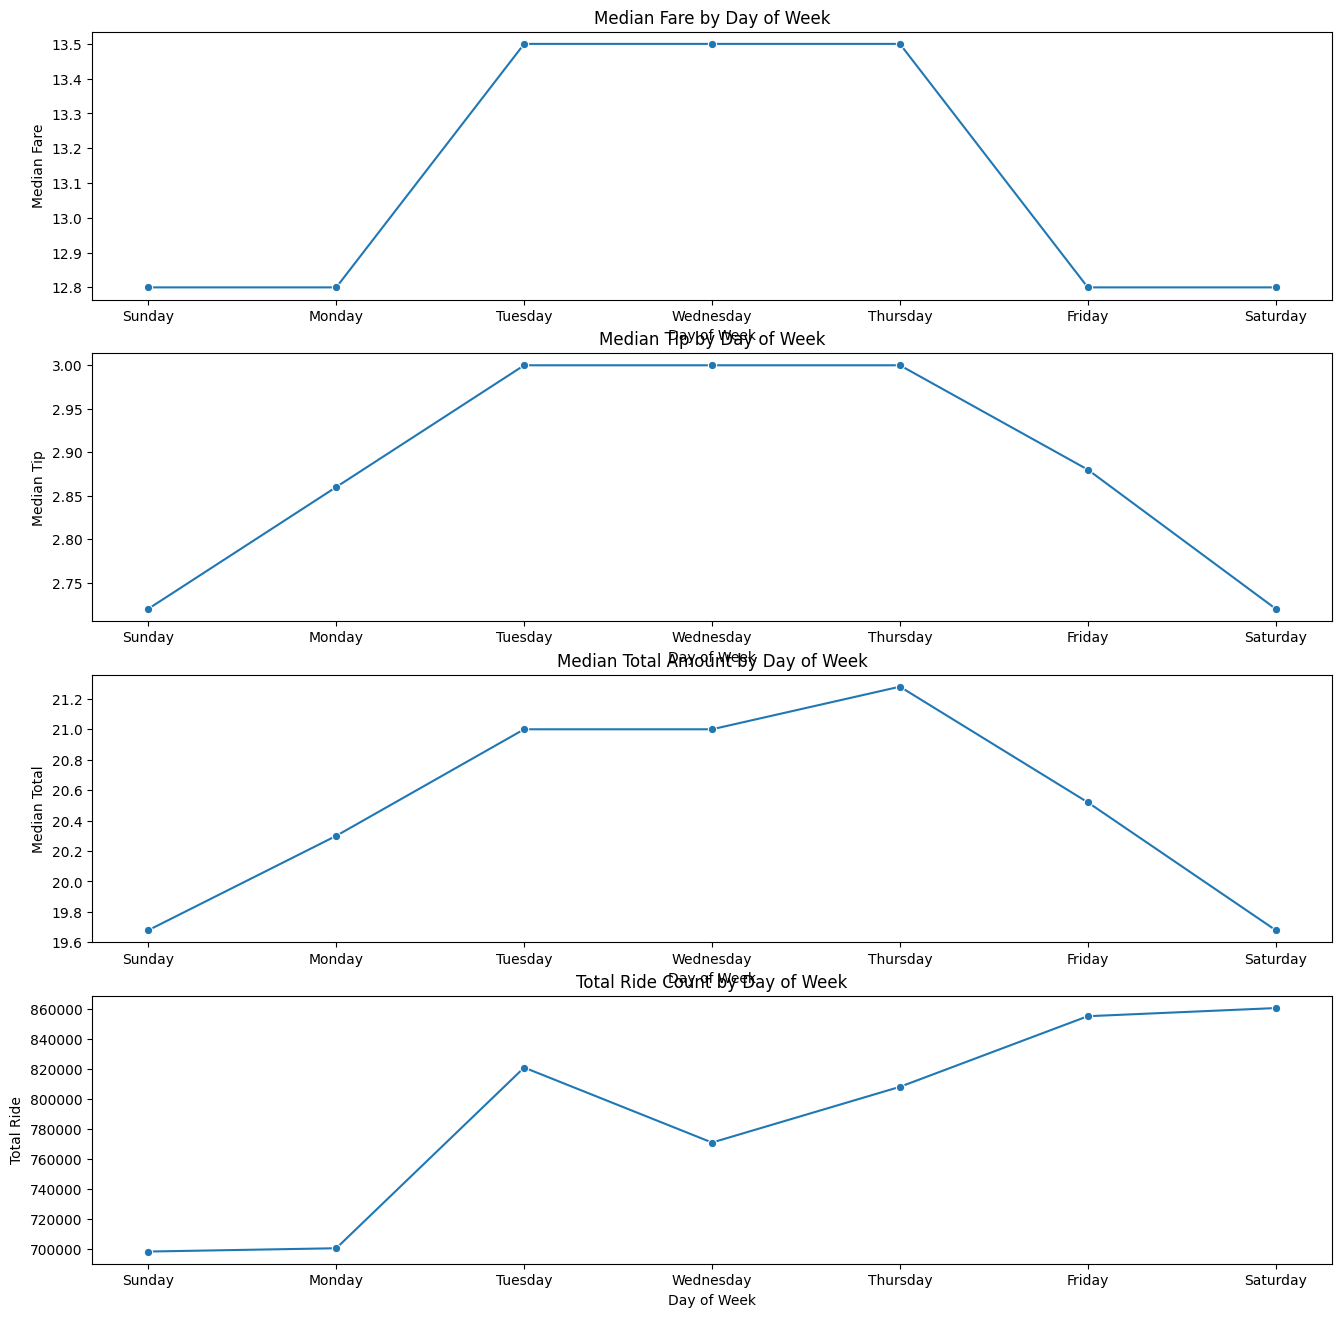

   day  fare_amount  tip_amount  total_amount  ride_count
0    1         12.8        2.72         19.68      698217
1    2         12.8        2.86         20.30      700420
2    3         13.5        3.00         21.00      820984
3    4         13.5        3.00         21.00      770946
4    5         13.5        3.00         21.28      808117
5    6         12.8        2.88         20.52      855241
6    7         12.8        2.72         19.68      860671


In [26]:

day_query = """
SELECT DAYOFWEEK(tpep_pickup_datetime), AVG(fare_amount) AS avg_fare, AVG(tip_amount) AS avg_tip, AVG(total_amount) AS avg_total, COUNT(*) AS count FROM nyc_taxi.yellow_taxi_clean GROUP BY DAYOFWEEK(tpep_pickup_datetime);
"""
day_fare = pd.read_sql(day_query, engine)
fig, axes = plt.subplots(4, 1, figsize=(16, 16))

sns.lineplot(data=median_day_f, x='day', y='fare_amount', marker='o', ax=axes[0])
sns.lineplot(data=median_day_f, x='day', y='tip_amount', marker='o', ax=axes[1])
sns.lineplot(data=median_day_f, x='day', y='total_amount', marker='o', ax=axes[2])
sns.lineplot(data=median_day_f, x='day', y='ride_count', marker='o', ax=axes[3])


axes[0].set_title('Median Fare by Day of Week')
axes[0].set_xlabel('Day of Week')
axes[0].set_ylabel('Median Fare')
axes[0].set_xticks([1,2,3,4,5,6,7])
axes[0].set_xticklabels(['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday'])

axes[1].set_title('Median Tip by Day of Week')
axes[1].set_xlabel('Day of Week')
axes[1].set_ylabel('Median Tip')
axes[1].set_xticks([1,2,3,4,5,6,7])
axes[1].set_xticklabels(['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday'])

axes[2].set_title('Median Total Amount by Day of Week')
axes[2].set_xlabel('Day of Week')
axes[2].set_ylabel('Median Total')
axes[2].set_xticks([1,2,3,4,5,6,7])
axes[2].set_xticklabels(['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday'])

axes[3].set_title('Total Ride Count by Day of Week')
axes[3].set_xlabel('Day of Week')
axes[3].set_ylabel('Total Ride')
axes[3].set_xticks([1,2,3,4,5,6,7])
axes[3].set_xticklabels(['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday'])

plt.show()
# Print the day fare DataFrame
print(median_day_f)

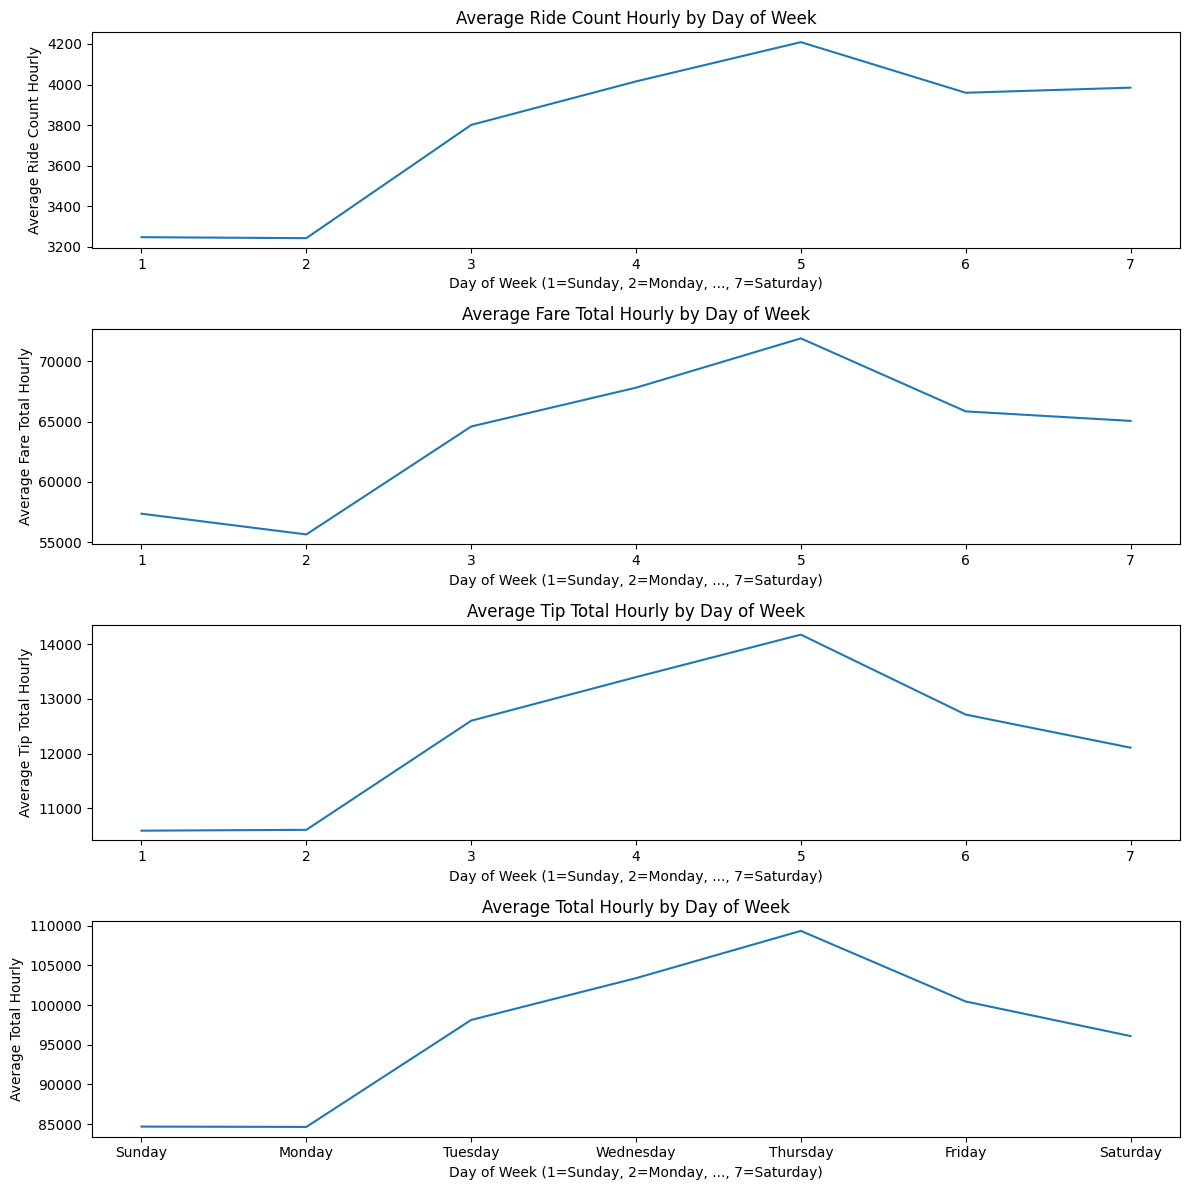

In [27]:
# day by day hourly
day_hour_query = """
SELECT day_of_week, AVG(ride_count) AS ride_count_hourly, AVG(fare_total) AS avg_fare_total_hourly, AVG(tip_total) AS avg_tip_total_hourly, AVG(total) AS avg_total_hourly FROM
(SELECT pickup_date , DAYOFWEEK(tpep_pickup_datetime) AS day_of_week, HOUR(tpep_pickup_datetime) as hour_of_day, COUNT(*) AS ride_count, SUM(fare_amount) as fare_total, SUM(tip_amount) as tip_total, SUM(total_amount) as total
FROM nyc_taxi.yellow_taxi_clean GROUP BY pickup_date , DAYOFWEEK(tpep_pickup_datetime),HOUR(tpep_pickup_datetime)) as day
GROUP BY day_of_week;
"""
day_hourly = pd.read_sql(day_hour_query, engine)
fig, axes = plt.subplots(4, 1, figsize=(12, 12))
sns.lineplot(data=day_hourly, x='day_of_week', y='ride_count_hourly', ax=axes[0])
sns.lineplot(data=day_hourly, x='day_of_week', y='avg_fare_total_hourly', ax=axes[1])
sns.lineplot(data=day_hourly, x='day_of_week', y='avg_tip_total_hourly', ax=axes[2])    
sns.lineplot(data=day_hourly, x='day_of_week', y='avg_total_hourly', ax=axes[3])
axes[0].set_title('Average Ride Count Hourly by Day of Week')
axes[1].set_title('Average Fare Total Hourly by Day of Week')
axes[2].set_title('Average Tip Total Hourly by Day of Week')
axes[3].set_title('Average Total Hourly by Day of Week')
axes[0].set_xlabel('Day of Week (1=Sunday, 2=Monday, ..., 7=Saturday)')
axes[1].set_xlabel('Day of Week (1=Sunday, 2=Monday, ..., 7=Saturday)')
axes[2].set_xlabel('Day of Week (1=Sunday, 2=Monday, ..., 7=Saturday)')
axes[3].set_xlabel('Day of Week (1=Sunday, 2=Monday, ..., 7=Saturday)')
axes[0].set_ylabel('Average Ride Count Hourly')
axes[1].set_ylabel('Average Fare Total Hourly')
axes[2].set_ylabel('Average Tip Total Hourly')
axes[3].set_ylabel('Average Total Hourly')
plt.xticks(ticks=[1, 2, 3, 4, 5, 6, 7], 
           labels=['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])
plt.tight_layout()
plt.show()


# Conditions vs average fare/tip/total
## Per ride
Numbers are very similar with the different conditions of all the different median. Not any big differences. 

## Per hour 
When weather is not clear on average there are more rides occuring hourly.  More rides means average total of fare, tip, and total is higher on average within non-clear weather compared to clear weather. As condition is worse the more all the averages increase.

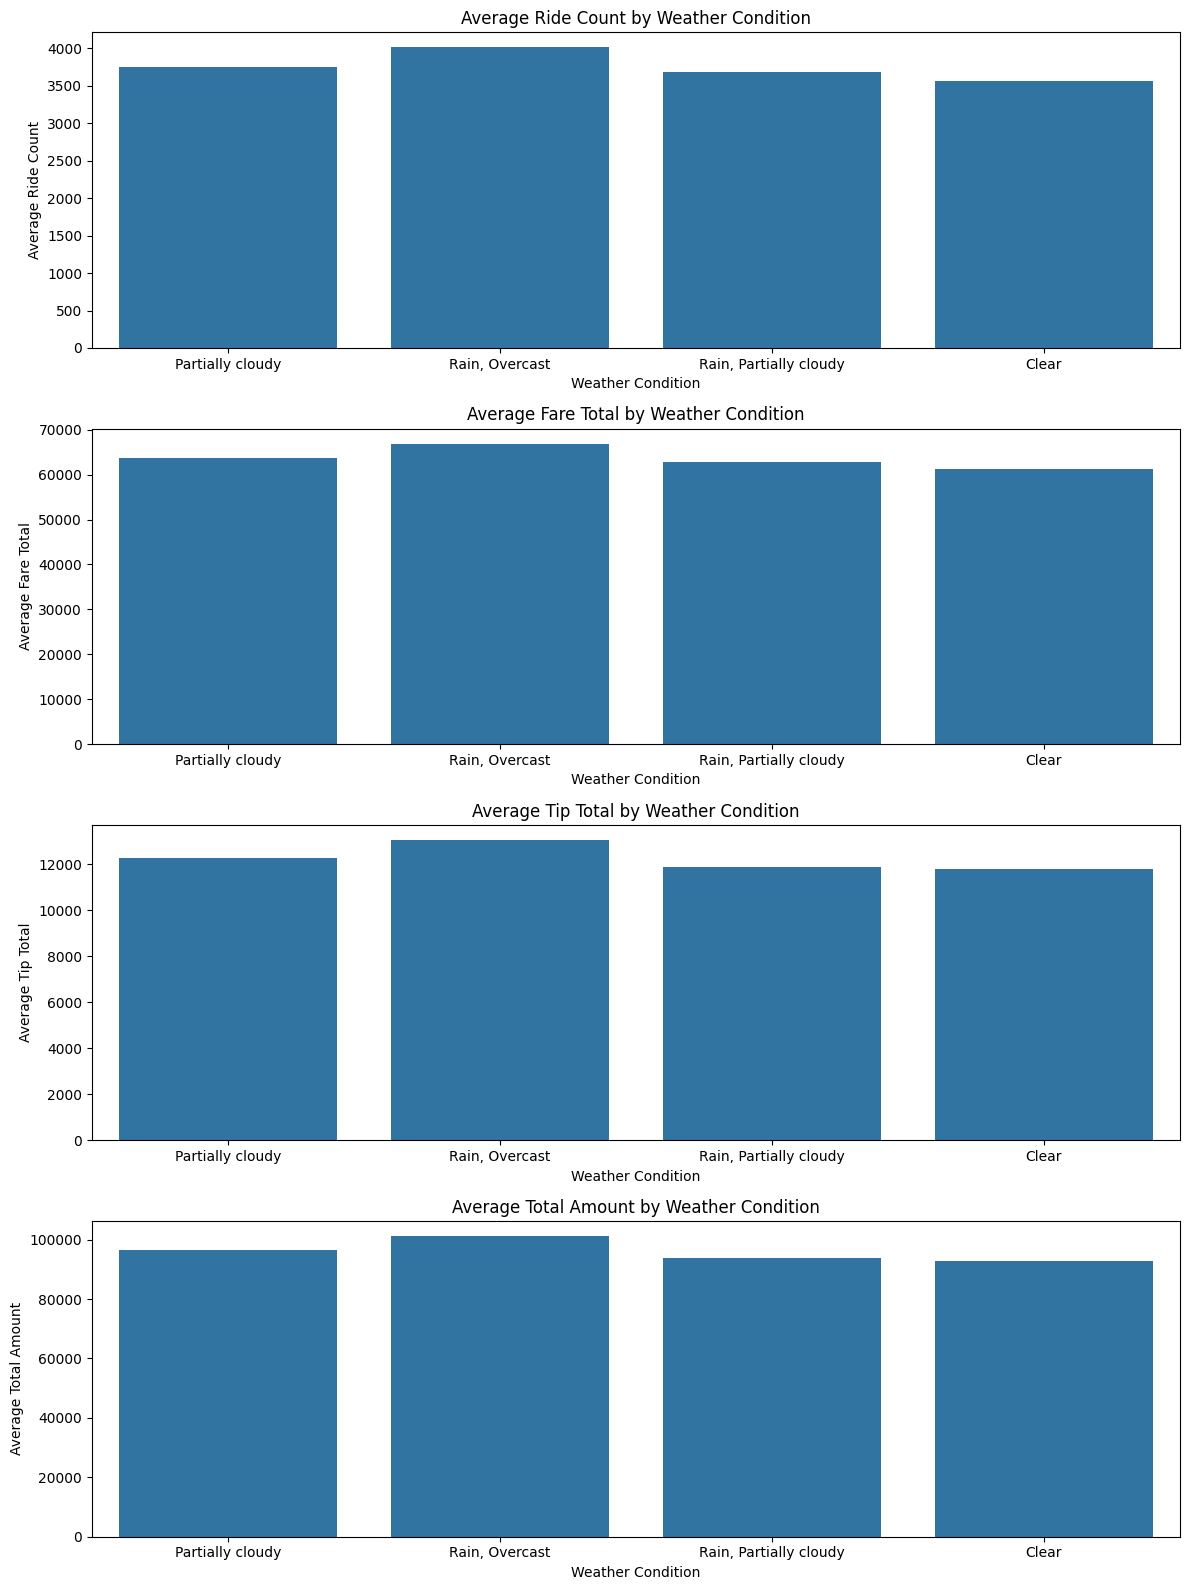

               conditions  ride_count_hourly  avg_fare_total_hourly  \
0        Partially cloudy          3756.0267           63723.290350   
1          Rain, Overcast          4013.3376           66887.641704   
2  Rain, Partially cloudy          3689.8833           62804.593083   
3                   Clear          3564.9688           61275.392396   

   avg_tip_total_hourly  avg_total_hourly  
0          12250.961650      96460.243717  
1          13054.073441     101184.125691  
2          11876.101111      93961.489167  
3          11772.352083      92773.187969  


In [28]:
# condition vs average fare amount
condition_query = """
SELECT conditions, AVG(ride_count) AS ride_count_hourly, AVG(fare_total) AS avg_fare_total_hourly, AVG(tip_total) AS avg_tip_total_hourly, AVG(total) AS avg_total_hourly FROM
(SELECT pickup_date , HOUR(tpep_pickup_datetime) as hour_of_day, conditions, COUNT(*) AS ride_count, SUM(fare_amount) as fare_total, SUM(tip_amount) as tip_total, SUM(total_amount) as total
FROM nyc_taxi.yellow_taxi_clean GROUP BY pickup_date , HOUR(tpep_pickup_datetime),conditions) AS hour_taxi
GROUP BY conditions;
"""
condition_stats = pd.read_sql(condition_query, engine)

fig, axes = plt.subplots(4,1, figsize=(12, 16))

sns.barplot(data=condition_stats, x='conditions', y='ride_count_hourly', ax=axes[0])
axes[0].set_title('Average Ride Count by Weather Condition')
axes[0].set_xlabel('Weather Condition')
axes[0].set_ylabel('Average Ride Count')

sns.barplot(data=condition_stats, x='conditions', y='avg_fare_total_hourly', ax=axes[1])
axes[1].set_title('Average Fare Total by Weather Condition')
axes[1].set_xlabel('Weather Condition')
axes[1].set_ylabel('Average Fare Total')

sns.barplot(data=condition_stats, x='conditions', y='avg_tip_total_hourly', ax=axes[2])
axes[2].set_title('Average Tip Total by Weather Condition')
axes[2].set_xlabel('Weather Condition')
axes[2].set_ylabel('Average Tip Total')

sns.barplot(data=condition_stats, x='conditions', y='avg_total_hourly', ax=axes[3])
axes[3].set_title('Average Total Amount by Weather Condition')
axes[3].set_xlabel('Weather Condition')
axes[3].set_ylabel('Average Total Amount')

plt.tight_layout()
plt.show()

print(condition_stats)


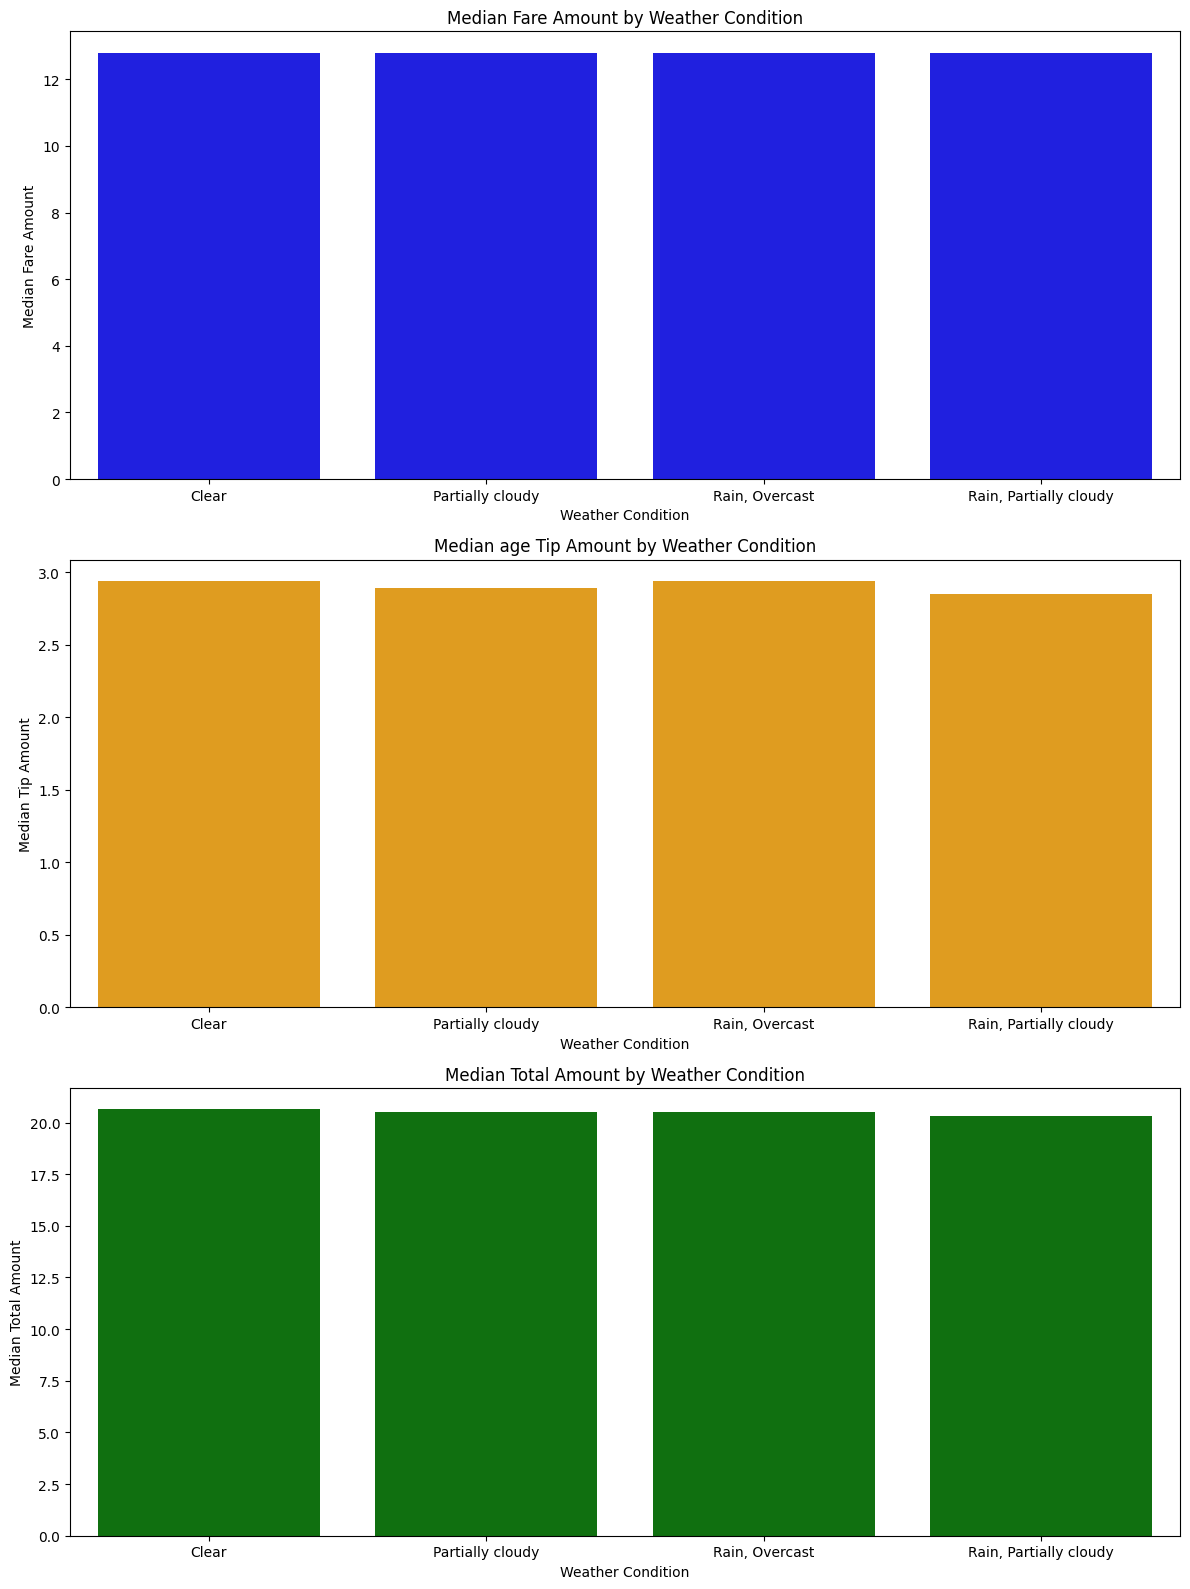

               conditions  fare_amount  tip_amount  total_amount  ride_count
0                   Clear         12.8        2.94         20.64      684474
1        Partially cloudy         12.8        2.89         20.52     2253616
2          Rain, Overcast         12.8        2.94         20.52     1248148
3  Rain, Partially cloudy         12.8        2.85         20.30     1328358


In [39]:



figs, axes = plt.subplots(3, 1, figsize=(12, 16))

sns.barplot(data=median_condition_f, x='conditions', y='fare_amount', color='blue', ax=axes[0])
sns.barplot(data=median_condition_f, x='conditions', y='tip_amount', color='orange', ax=axes[1])
sns.barplot(data=median_condition_f, x='conditions', y='total_amount', color='green', ax=axes[2])
axes[0].set_title('Median Fare Amount by Weather Condition')
axes[1].set_title('Median age Tip Amount by Weather Condition')
axes[2].set_title('Median Total Amount by Weather Condition')
axes[0].set_xlabel('Weather Condition')
axes[1].set_xlabel('Weather Condition')
axes[2].set_xlabel('Weather Condition')
axes[0].set_ylabel('Median Fare Amount')
axes[1].set_ylabel('Median Tip Amount')
axes[2].set_ylabel('Median Total Amount')

plt.tight_layout()
plt.show()

print(median_condition_f)

# Weather(temperature, cloud cover, windspeed, and precipitation)

Made line plots of weather features vs their average ride count, fare, tip, and total amount hourly to visualize their patterns and understand the weather's influence on demand and revenue. Queried data from 10am, 2pm, 8pm to get different times of the day that is less impacted by rush hours, commuting, and overnight times. Complex patterns are seen but these patterns could mean nothing however they could still have relationships with other features for example each zone could have patterns with specific weather features that can influence either demand or revenue.

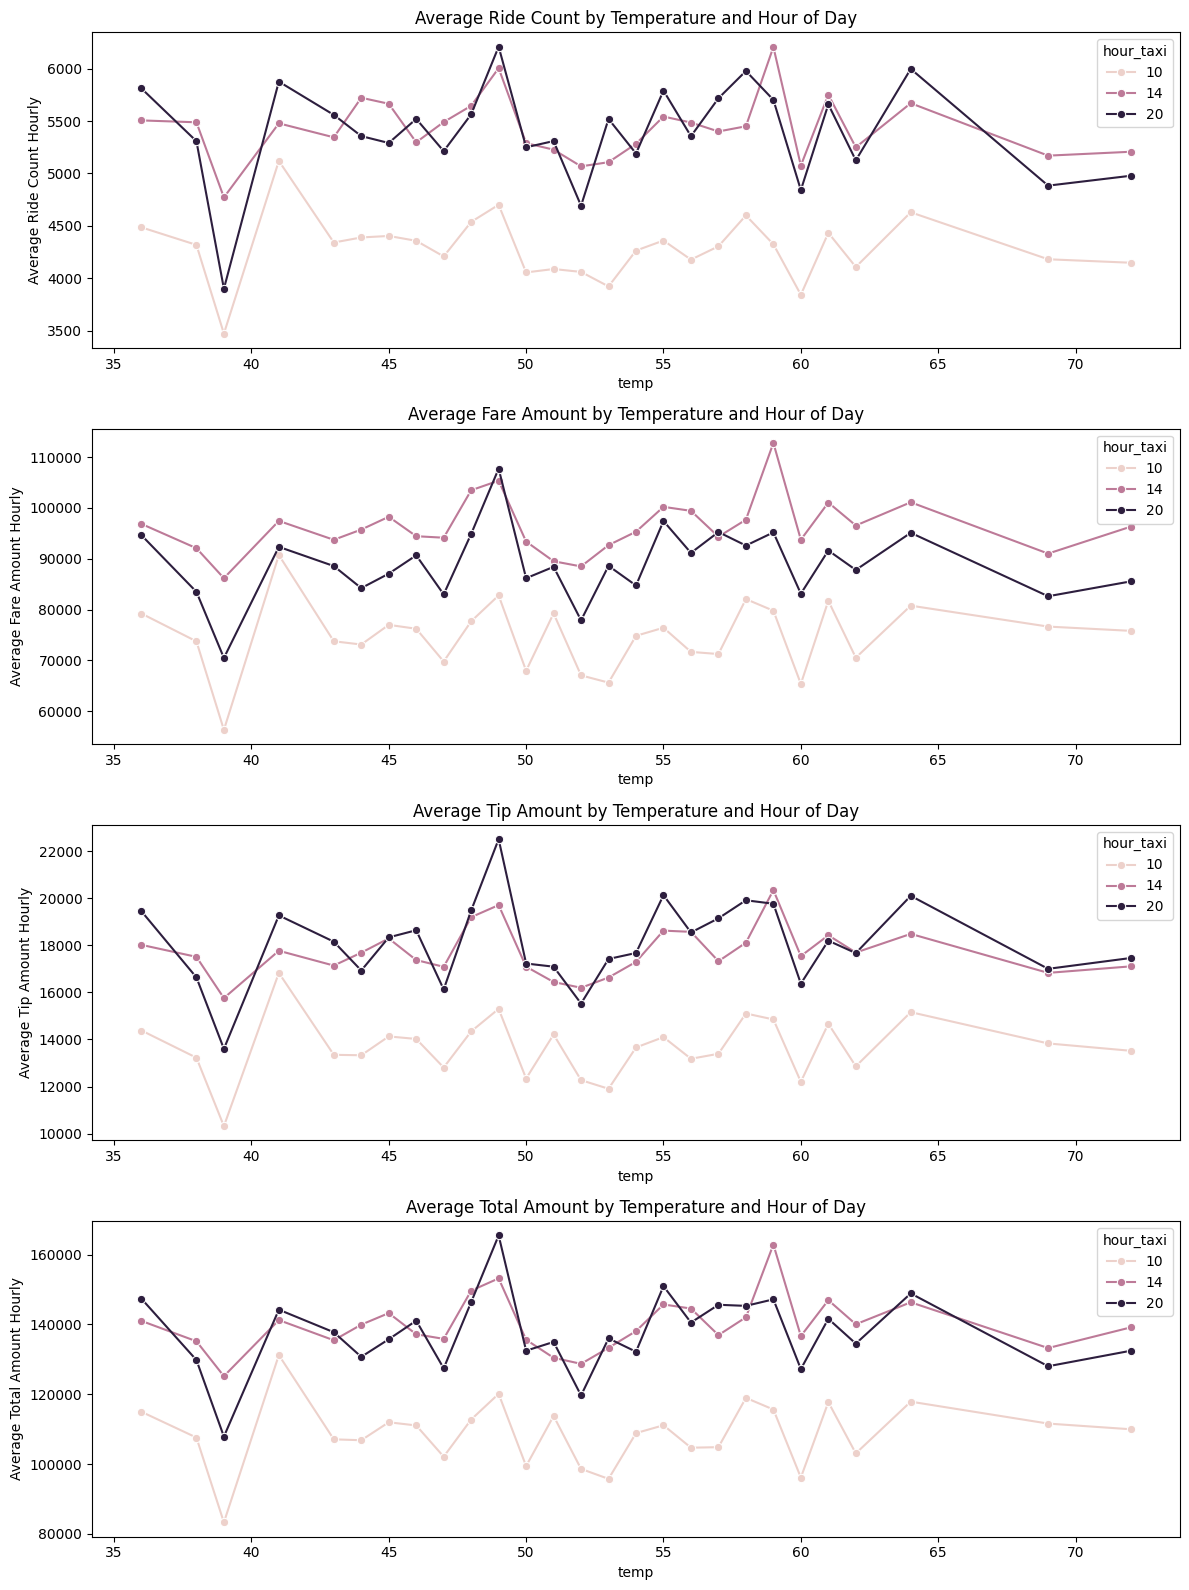

In [29]:
temp_query = """
SELECT temp, hour_taxi, AVG(count_of_rides) AS avg_count_of_rides, AVG(fare_sum) AS avg_fair_sum, AVG(tip_sum) AS avg_tip_sum, AVG(total_sum) AS avg_total_sum
FROM (SELECT pickup_date, HOUR(tpep_pickup_datetime) AS hour_taxi, ROUND(temp) AS temp, COUNT(*) AS count_of_rides, SUM(fare_amount) AS fare_sum, SUM(tip_amount) AS tip_sum , SUM(total_amount) AS total_sum 
FROM nyc_taxi.yellow_taxi_clean GROUP BY pickup_date , HOUR(tpep_pickup_datetime), ROUND(temp)) AS temp_by_hour
WHERE hour_taxi IN (10,14,20)
GROUP BY temp,hour_taxi
ORDER BY temp, hour_taxi;
"""
temp_stats = pd.read_sql(temp_query, engine)
fig, axes = plt.subplots(4, 1, figsize=(12, 16))

sns.lineplot(data=temp_stats, x='temp', y='avg_count_of_rides', hue='hour_taxi', ax=axes[0], marker='o')
axes[0].set_title('Average Ride Count by Temperature and Hour of Day')
axes[0].set_ylabel('Average Ride Count Hourly')
sns.lineplot(data=temp_stats, x='temp', y='avg_fair_sum', hue='hour_taxi', ax=axes[1], marker='o')
axes[1].set_title('Average Fare Amount by Temperature and Hour of Day')
axes[1].set_ylabel('Average Fare Amount Hourly')
sns.lineplot(data=temp_stats, x='temp', y='avg_tip_sum', hue='hour_taxi', ax=axes[2], marker='o')
axes[2].set_title('Average Tip Amount by Temperature and Hour of Day')
axes[2].set_ylabel('Average Tip Amount Hourly')
sns.lineplot(data=temp_stats, x='temp', y='avg_total_sum', hue='hour_taxi', ax=axes[3], marker='o')
axes[3].set_title('Average Total Amount by Temperature and Hour of Day')
axes[3].set_ylabel('Average Total Amount Hourly')
plt.tight_layout()
plt.show()

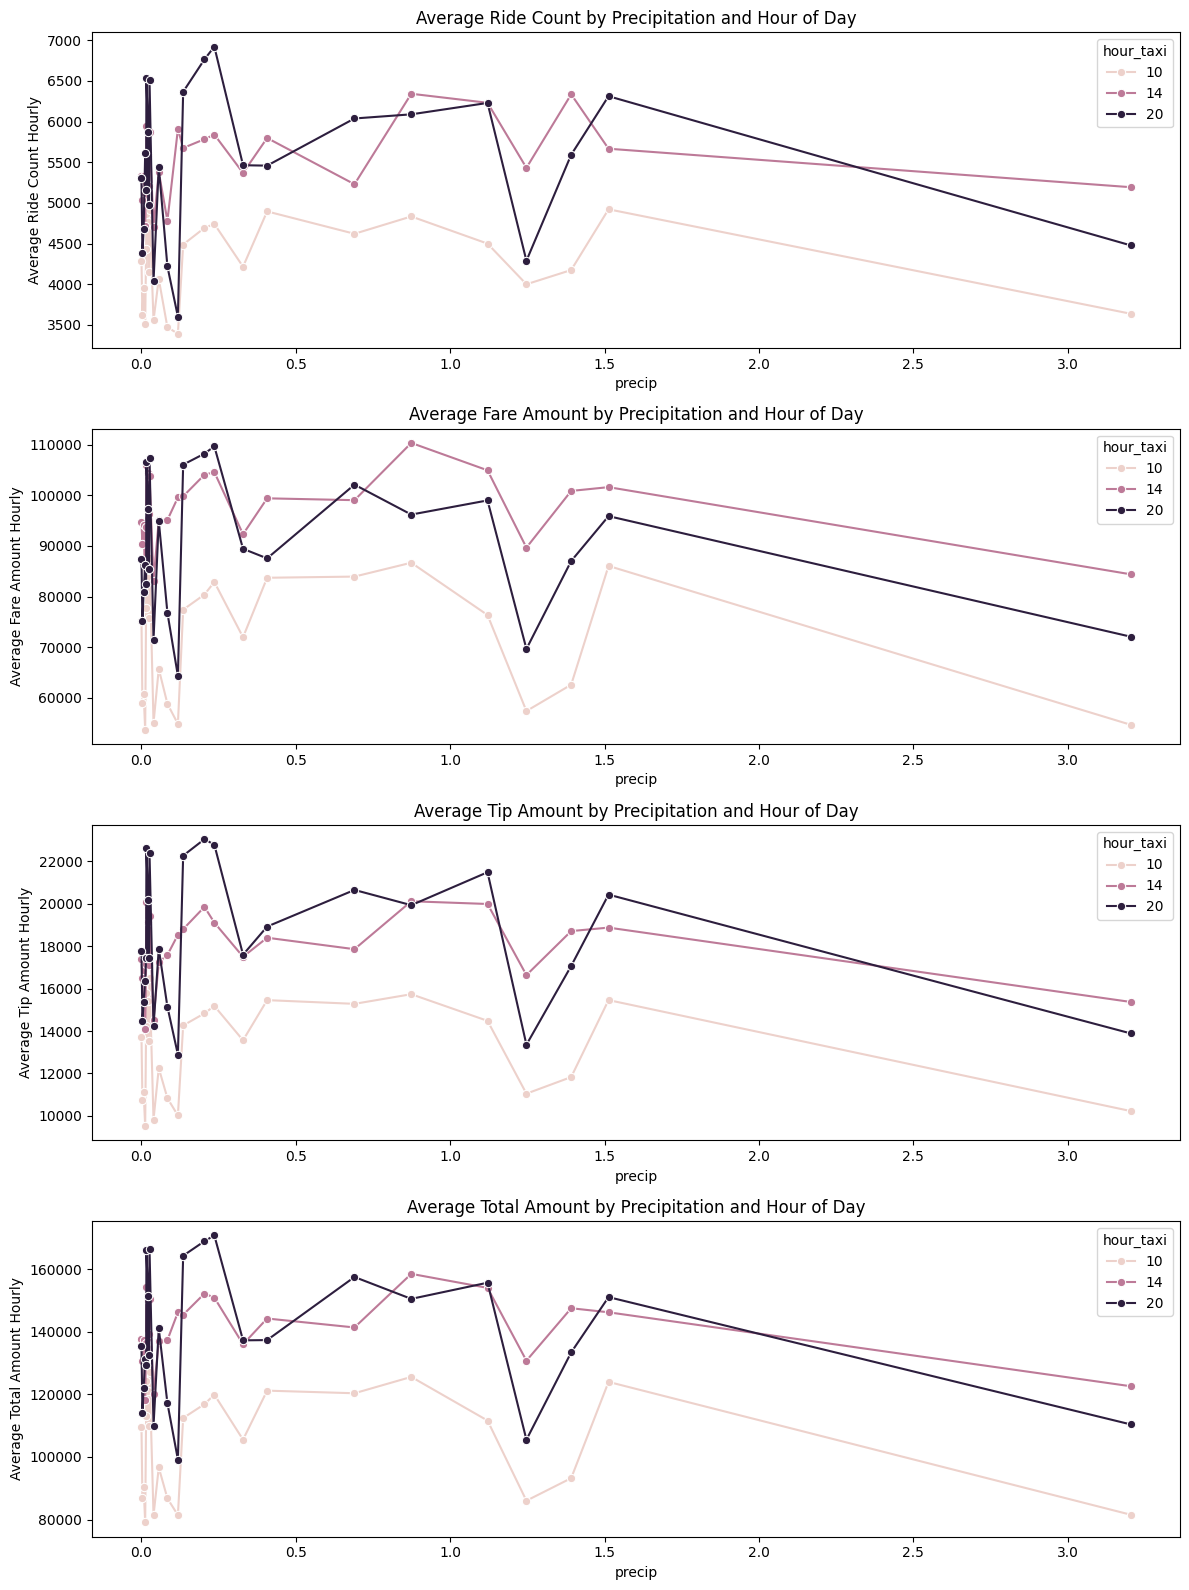

In [30]:
percip_query = """
SELECT precip, hour_taxi, AVG(count_of_rides) AS avg_count_of_rides, AVG(fare_sum) AS avg_fair_sum, AVG(tip_sum) AS avg_tip_sum, AVG(total_sum) AS avg_total_sum
FROM (SELECT pickup_date, HOUR(tpep_pickup_datetime) AS hour_taxi, precip, COUNT(*) AS count_of_rides, SUM(fare_amount) AS fare_sum, SUM(tip_amount) AS tip_sum , SUM(total_amount) AS total_sum
FROM nyc_taxi.yellow_taxi_clean GROUP BY pickup_date , HOUR(tpep_pickup_datetime),precip) AS temp_by_hour
WHERE hour_taxi IN (10,14,20)
GROUP BY precip,hour_taxi
ORDER BY precip, hour_taxi;
"""
precip_stats = pd.read_sql(percip_query, engine)
fig, axes = plt.subplots(4, 1, figsize=(12, 16))
sns.lineplot(data=precip_stats, x='precip', y='avg_count_of_rides', hue='hour_taxi', ax=axes[0], marker='o')
axes[0].set_title('Average Ride Count by Precipitation and Hour of Day')
axes[0].set_ylabel('Average Ride Count Hourly')
sns.lineplot(data=precip_stats, x='precip', y='avg_fair_sum', hue='hour_taxi', ax=axes[1], marker='o')
axes[1].set_title('Average Fare Amount by Precipitation and Hour of Day')
axes[1].set_ylabel('Average Fare Amount Hourly')
sns.lineplot(data=precip_stats, x='precip', y='avg_tip_sum', hue='hour_taxi', ax=axes[2], marker='o')
axes[2].set_title('Average Tip Amount by Precipitation and Hour of Day')
axes[2].set_ylabel('Average Tip Amount Hourly')
sns.lineplot(data=precip_stats, x='precip', y='avg_total_sum', hue='hour_taxi', ax=axes[3], marker='o')
axes[3].set_title('Average Total Amount by Precipitation and Hour of Day')
axes[3].set_ylabel('Average Total Amount Hourly')
plt.tight_layout()
plt.show()

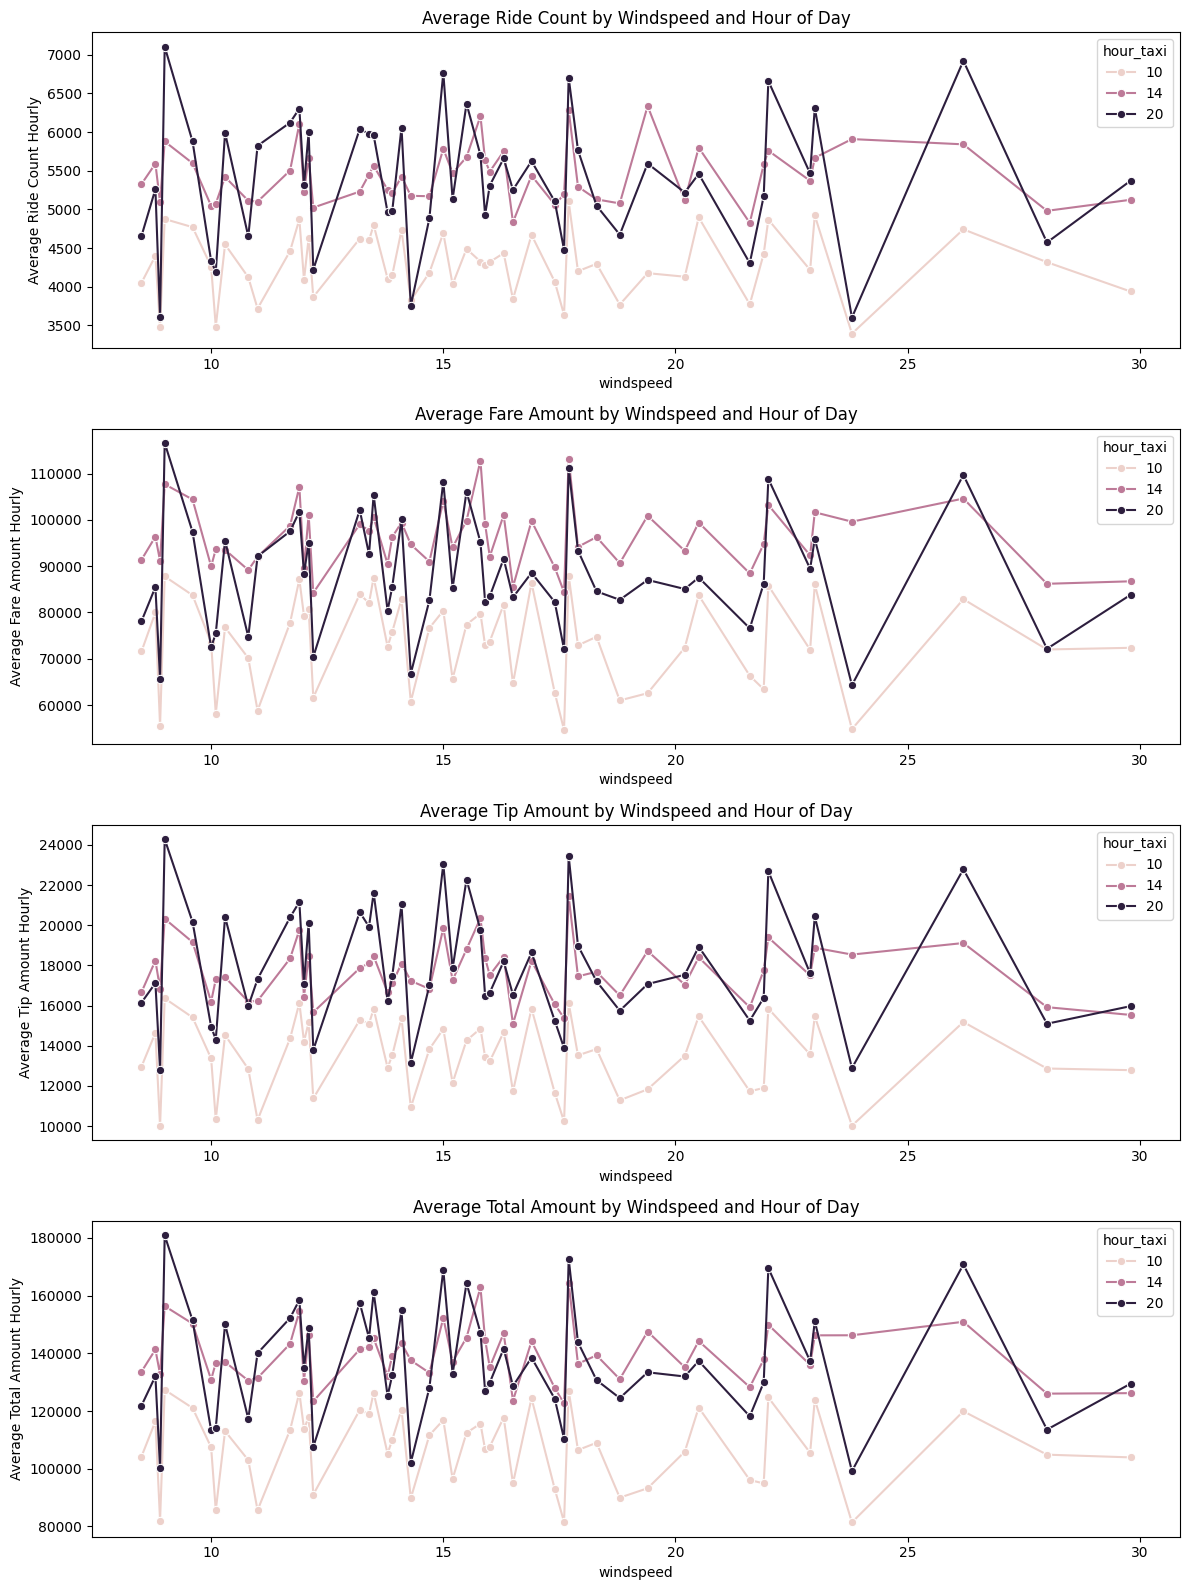

In [31]:
windspeed_query = """
SELECT windspeed, hour_taxi, AVG(count_of_rides) AS avg_count_of_rides, AVG(fare_sum) AS avg_fair_sum, AVG(tip_sum) AS avg_tip_sum, AVG(total_sum) AS avg_total_sum
FROM (SELECT pickup_date, HOUR(tpep_pickup_datetime) as hour_taxi, windspeed, COUNT(*) as count_of_rides, SUM(fare_amount) AS fare_sum, SUM(tip_amount) AS tip_sum , SUM(total_amount) AS total_sum
FROM nyc_taxi.yellow_taxi_clean GROUP BY pickup_date , HOUR(tpep_pickup_datetime),windspeed) AS temp_by_hour
WHERE hour_taxi IN (10,14,20)
GROUP BY windspeed,hour_taxi
ORDER BY windspeed, hour_taxi;
"""
windspeed_stats = pd.read_sql(windspeed_query, engine)
fig, axes = plt.subplots(4, 1, figsize=(12, 16))
sns.lineplot(data=windspeed_stats, x='windspeed', y='avg_count_of_rides', hue='hour_taxi', ax=axes[0], marker='o')
axes[0].set_title('Average Ride Count by Windspeed and Hour of Day')
axes[0].set_ylabel('Average Ride Count Hourly')
sns.lineplot(data=windspeed_stats, x='windspeed', y='avg_fair_sum', hue='hour_taxi', ax=axes[1], marker='o')
axes[1].set_title('Average Fare Amount by Windspeed and Hour of Day')
axes[1].set_ylabel('Average Fare Amount Hourly')
sns.lineplot(data=windspeed_stats, x='windspeed', y='avg_tip_sum', hue='hour_taxi', ax=axes[2], marker='o')
axes[2].set_title('Average Tip Amount by Windspeed and Hour of Day')
axes[2].set_ylabel('Average Tip Amount Hourly')
sns.lineplot(data=windspeed_stats, x='windspeed', y='avg_total_sum', hue='hour_taxi', ax=axes[3], marker='o')
axes[3].set_title('Average Total Amount by Windspeed and Hour of Day')
axes[3].set_ylabel('Average Total Amount Hourly')
plt.tight_layout()
plt.show()

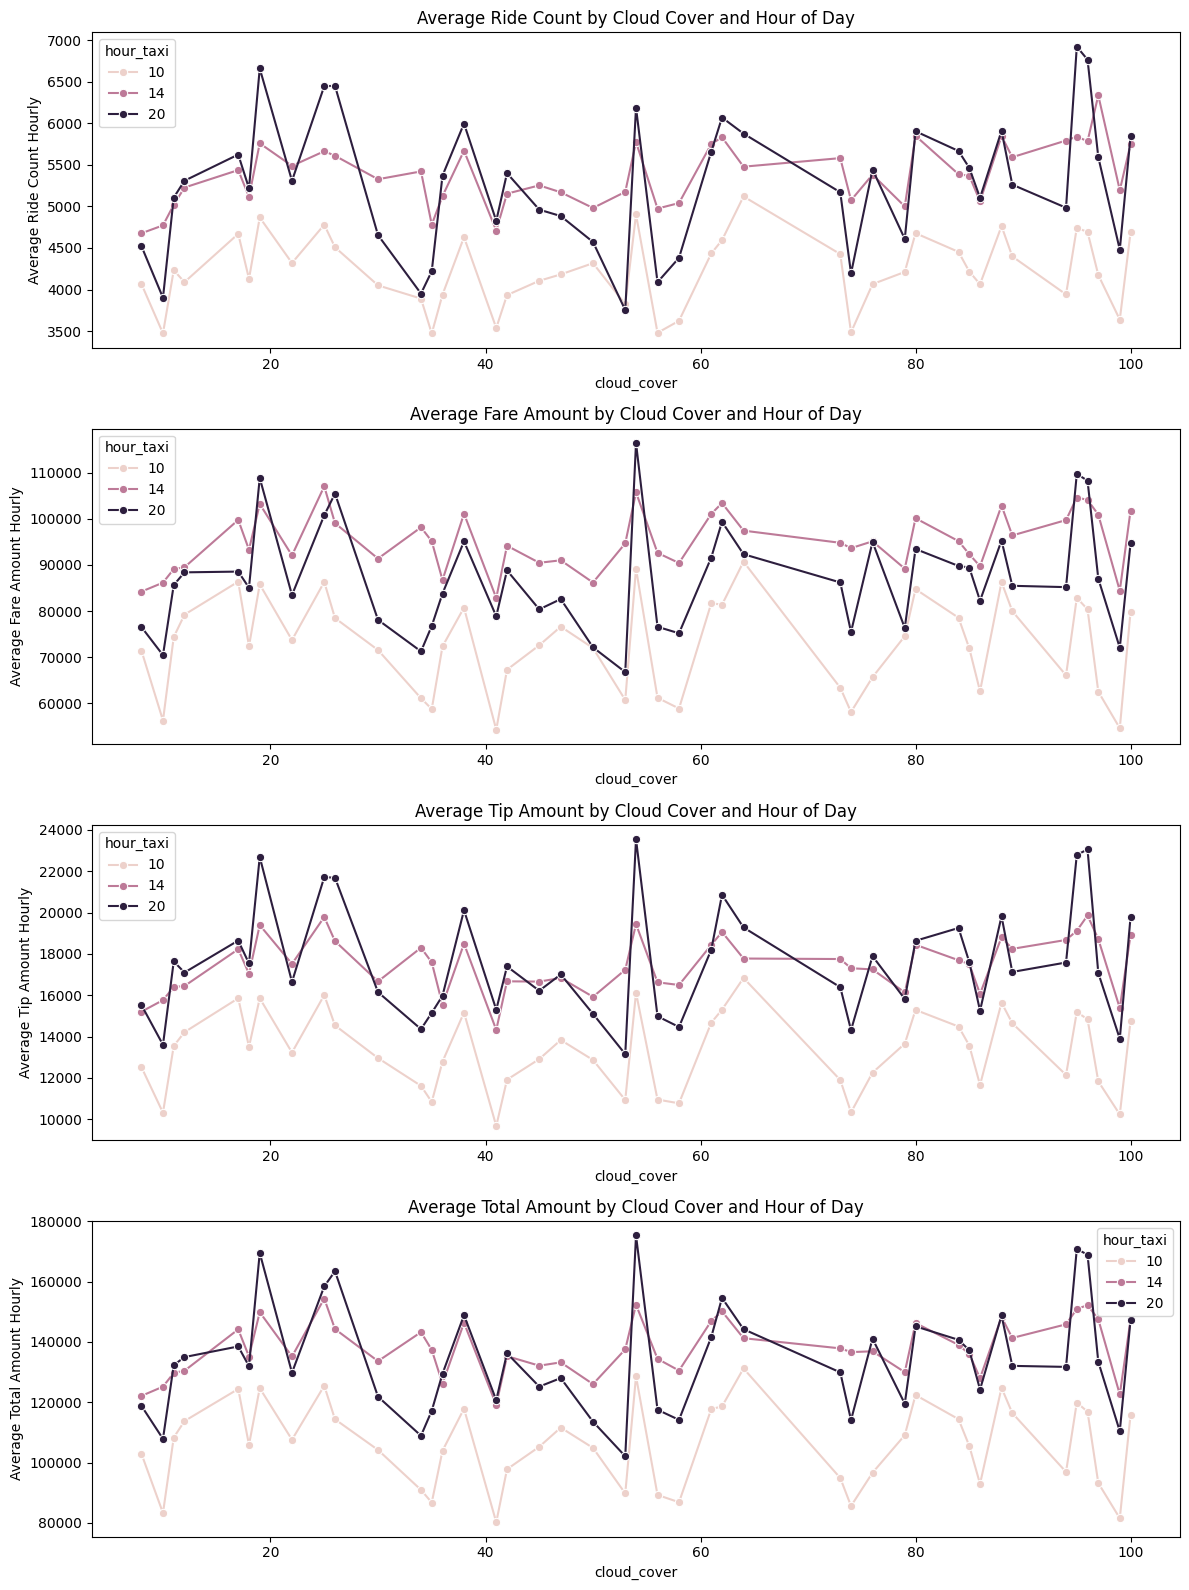

In [32]:
cloud_cover_query = """
SELECT cloud_cover, hour_taxi, AVG(count_of_rides) AS avg_count_of_rides, AVG(fare_sum) as avg_fair_sum, AVG(tip_sum) as avg_tip_sum, AVG(total_sum) as avg_total_sum
FROM (SELECT pickup_date, HOUR(tpep_pickup_datetime) as hour_taxi, ROUND(cloudcover) as cloud_cover, COUNT(*) as count_of_rides, SUM(fare_amount) AS fare_sum, SUM(tip_amount) AS tip_sum , SUM(total_amount) AS total_sum 
FROM nyc_taxi.yellow_taxi_clean GROUP BY pickup_date , HOUR(tpep_pickup_datetime),ROUND(cloudcover)) AS temp_by_hour
WHERE hour_taxi IN (10,14,20)
GROUP BY cloud_cover,hour_taxi
ORDER BY cloud_cover, hour_taxi;
"""
cloud_cover_stats = pd.read_sql(cloud_cover_query, engine)
fig, axes = plt.subplots(4, 1, figsize=(12, 16))
sns.lineplot(data=cloud_cover_stats, x='cloud_cover', y='avg_count_of_rides', hue='hour_taxi', ax=axes[0], marker='o')
axes[0].set_title('Average Ride Count by Cloud Cover and Hour of Day')
axes[0].set_ylabel('Average Ride Count Hourly')
sns.lineplot(data=cloud_cover_stats, x='cloud_cover', y='avg_fair_sum', hue='hour_taxi', ax=axes[1], marker='o')
axes[1].set_title('Average Fare Amount by Cloud Cover and Hour of Day')
axes[1].set_ylabel('Average Fare Amount Hourly')
sns.lineplot(data=cloud_cover_stats, x='cloud_cover', y='avg_tip_sum', hue='hour_taxi', ax=axes[2], marker='o')
axes[2].set_title('Average Tip Amount by Cloud Cover and Hour of Day')
axes[2].set_ylabel('Average Tip Amount Hourly')
sns.lineplot(data=cloud_cover_stats, x='cloud_cover', y='avg_total_sum', hue='hour_taxi', ax=axes[3], marker='o')
axes[3].set_title('Average Total Amount by Cloud Cover and Hour of Day')
axes[3].set_ylabel('Average Total Amount Hourly')
plt.tight_layout()
plt.show()

# Machine Learning section


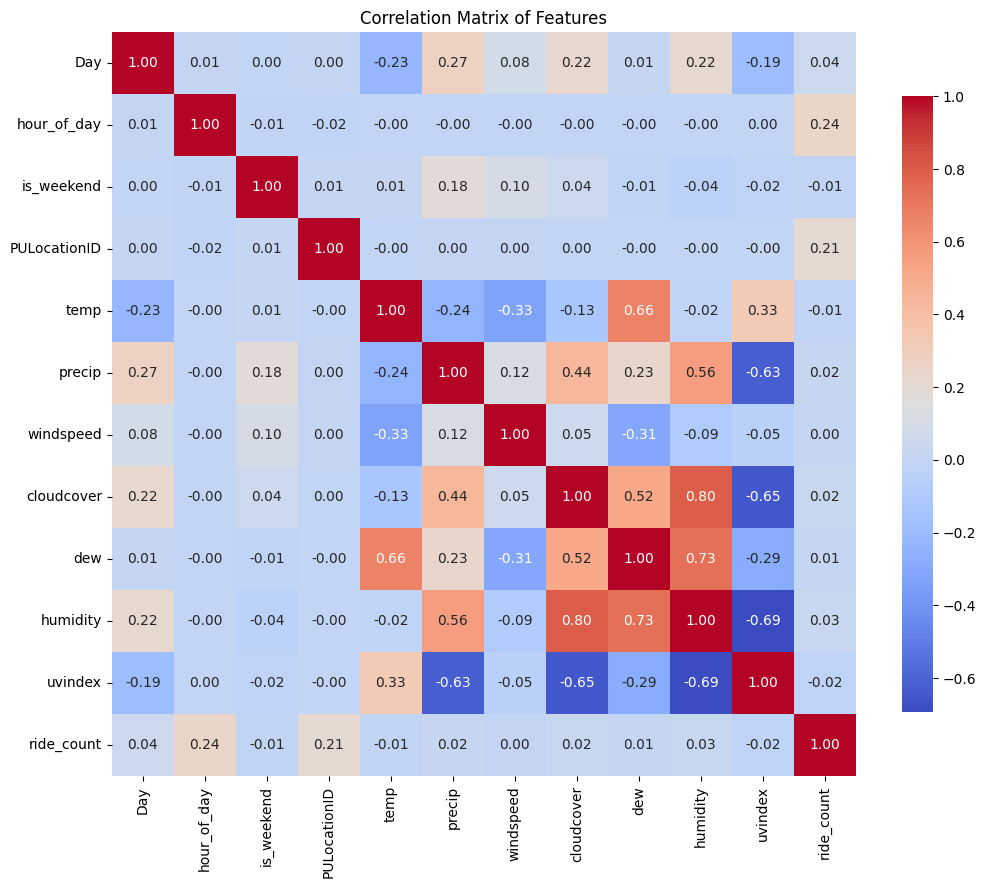

In [34]:
#check for multicollinearity
multicollinearity_query = """
SELECT  DAYOFWEEK(pickup_date) as Day , HOUR(tpep_pickup_datetime) as hour_of_day,  CASE WHEN DAYOFWEEK(pickup_date) BETWEEN  2 and 6 THEN 0 ELSE 1 END AS is_weekend ,PULocationID, temp, precip,
	windspeed, cloudcover, dew, humidity, uvindex,
    COUNT(*) as ride_count
FROM  nyc_taxi.yellow_taxi_clean
GROUP BY  DAYOFWEEK(pickup_date), HOUR(tpep_pickup_datetime), PULocationID, temp,precip, windspeed, cloudcover, dew, humidity, uvindex, CASE WHEN DAYOFWEEK(pickup_date) BETWEEN 2 and 6 THEN 0 ELSE 1 END
ORDER BY  DAYOFWEEK(pickup_date), hour_of_day, PULocationID;
"""
multicollinearity_data = pd.read_sql(multicollinearity_query, engine)
corr_matrix = multicollinearity_data.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix of Features')
plt.show()

## multicollinearity verification

From the correlation matrix, `dew`, `humidity`, and `uvindex` are highly correlated with other variables such as `temperature `and `cloudcover`. 
To reduce redundancy and multicollinearity, we retain variables that are more independent or kept one variable that is highly similar to multiple other variables including `temperature`, `cloud_cover`, `precipitation`, and `windspeed`."




In [35]:
query = """
SELECT  DAYOFWEEK(pickup_date) as Day , HOUR(tpep_pickup_datetime) as hour_of_day,  CASE WHEN DAYOFWEEK(pickup_date) BETWEEN  2 and 6 THEN 0 ELSE 1 END AS is_weekend ,PULocationID, temp, precip,
	windspeed, cloudcover,
    COUNT(*) as ride_count
FROM  nyc_taxi.yellow_taxi_clean
GROUP BY  DAYOFWEEK(pickup_date), HOUR(tpep_pickup_datetime), PULocationID, temp,precip, windspeed, cloudcover, CASE WHEN DAYOFWEEK(pickup_date) BETWEEN 2 and 6 THEN 0 ELSE 1 END
ORDER BY  DAYOFWEEK(pickup_date), hour_of_day, PULocationID;
"""
taxi_data = pd.read_sql(query, engine)
print(taxi_data.info())
print(taxi_data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131196 entries, 0 to 131195
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Day           131196 non-null  int64  
 1   hour_of_day   131196 non-null  int64  
 2   is_weekend    131196 non-null  int64  
 3   PULocationID  131196 non-null  int64  
 4   temp          131196 non-null  float64
 5   precip        131196 non-null  float64
 6   windspeed     131196 non-null  float64
 7   cloudcover    131196 non-null  float64
 8   ride_count    131196 non-null  int64  
dtypes: float64(4), int64(5)
memory usage: 9.0 MB
None
                 Day    hour_of_day     is_weekend   PULocationID  \
count  131196.000000  131196.000000  131196.000000  131196.000000   
mean        4.000305      11.901239       0.287890     140.333303   
std         2.017134       6.412939       0.452781      74.805163   
min         1.000000       0.000000       0.000000       1.000000   
25%   

# Splitting our Data
We split the data into a test/train (80/20). One to train our data for our ml models and later to test the ml model.

In [4]:
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
x = pd.concat([taxi_data['Day'], taxi_data['hour_of_day'] , taxi_data['PULocationID'], taxi_data['temp'], taxi_data['precip'], taxi_data['windspeed'], taxi_data['cloudcover']], axis=1)
y = taxi_data['ride_count']

train_data, test_data, train_labels, test_labels = train_test_split(x, y, test_size=0.2, random_state= 67)



# Linear regression Model
Our linear regression model did not give us either a high mse or a low R^2 score and this is because our variables consist of complex and nonlinear patterrns that our linear regression model won't be able to capture.

Mean Squared Error: 4232.881826001015
R^2 Score: 0.10680803945333217


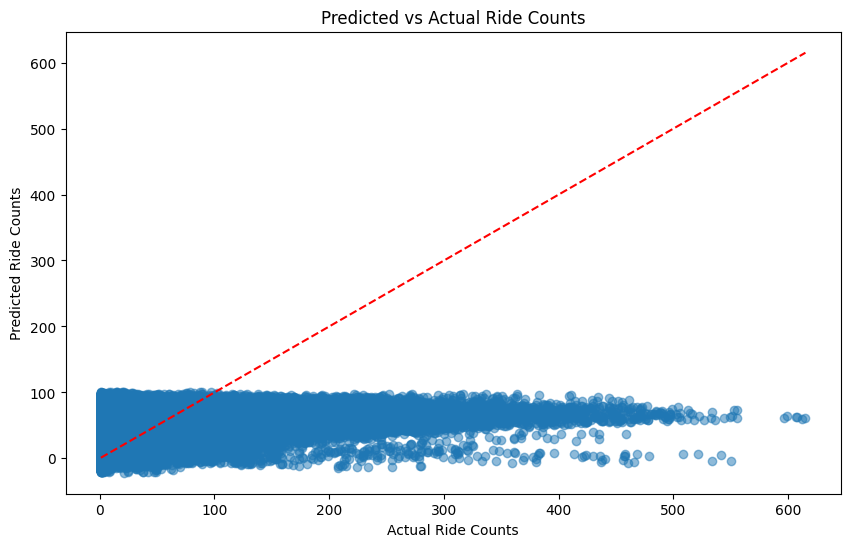

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
# Create a linear regression model
model = LinearRegression()
# Fit the model to the training data
model.fit(train_data, train_labels)
# Predict on the test data
predictions = model.predict(train_data)
# Evaluate the model
mse = mean_squared_error(train_labels, predictions)
r2 = r2_score(train_labels, predictions)
print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')
# Visualize the predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(train_labels, predictions, alpha=0.5)
plt.plot([train_labels.min(), train_labels.max()], [train_labels.min(), train_labels.max()], color='red', linestyle='--')
plt.title('Predicted vs Actual Ride Counts')
plt.xlabel('Actual Ride Counts')
plt.ylabel('Predicted Ride Counts')
plt.show()

# Random Forest Regression Model

Random Forest Mean Squared Error: 22.125453452875497
Random Forest R^2 Score: 0.9953312476086231


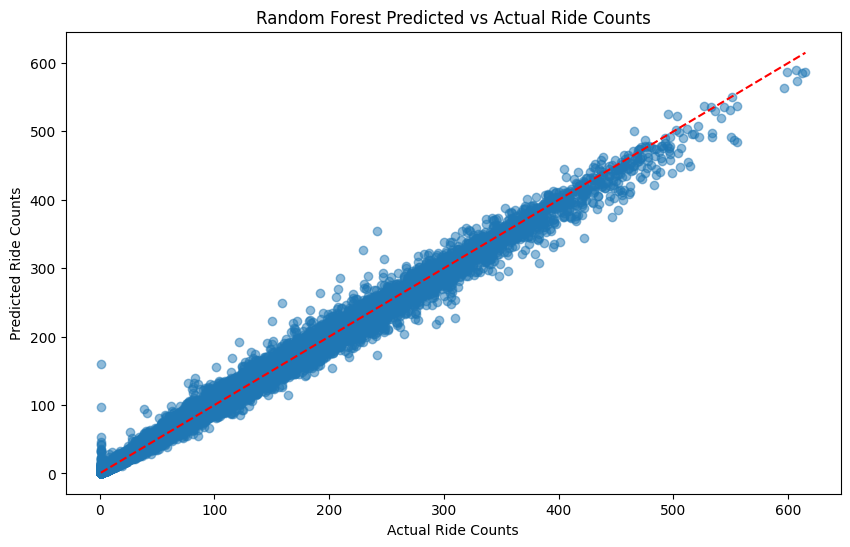

In [6]:
# Random Forest Regression
from sklearn.ensemble import RandomForestRegressor
# Create a random forest regression model
rf_model = RandomForestRegressor(n_estimators=100, random_state=67)
# Fit the model to the training data
rf_model.fit(train_data, train_labels)
# Predict on the test data
rf_predictions = rf_model.predict(train_data)
# Evaluate the model
rf_mse = mean_squared_error(train_labels, rf_predictions)
rf_r2 = r2_score(train_labels, rf_predictions)
print(f'Random Forest Mean Squared Error: {rf_mse}')
print(f'Random Forest R^2 Score: {rf_r2}')
# Visualize the predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(train_labels, rf_predictions, alpha=0.5)
plt.plot([train_labels.min(), train_labels.max()], [train_labels.min(), train_labels.max()], color='red', linestyle='--')
plt.title('Random Forest Predicted vs Actual Ride Counts')
plt.xlabel('Actual Ride Counts')
plt.ylabel('Predicted Ride Counts')
plt.show()

We  tried a random forest model which preformed too well at first overfitting so we had to hypertune to figure the best parameters for our random forest model and this stopped our model from overfitting giving us a good MSE and R^2 score. This model captured the data well seen from the low MSE score and low R^2 score.

In [7]:

train_predictions_rf = rf_model.predict(train_data)
train_mse_rf = mean_squared_error(train_labels, train_predictions_rf)
train_r2_rf = r2_score(train_labels, train_predictions_rf)
print(f'Random Forest Training Mean Squared Error: {train_mse_rf}')
print(f'Random Forest Training R^2 Score: {train_r2_rf}')
# overfit so we need to hyperparameter tune


Random Forest Training Mean Squared Error: 22.125453452875497
Random Forest Training R^2 Score: 0.9953312476086231


# Hypertuning
Hypertuned to find best parameter for our model and the turn out of our random forest regression model is a good MSE/R^2 Score

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 200}
Tuned Random Forest Mean Squared Error: 100.59896116487693
Tuned Random Forest R^2 Score: 0.9787723383157371


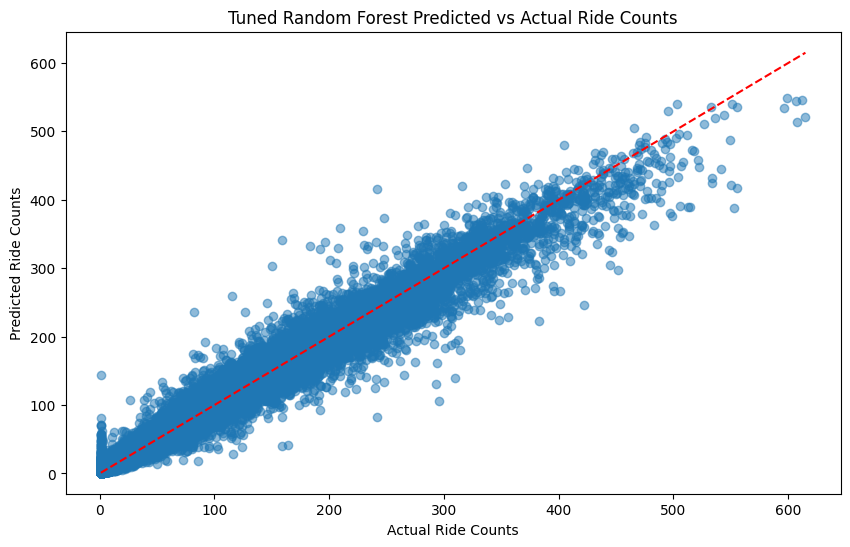

In [8]:
# hyperparameter tuning to find the best parameters for the random forest model without overfitting
from sklearn.model_selection import GridSearchCV
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [10, 20, 50],
    'min_samples_leaf': [5, 10, 20]
}
# Create a random forest regression model
rf_model_tuned = RandomForestRegressor(random_state=67)
# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=rf_model_tuned, param_grid=param_grid,  cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
# Fit the grid search to the training data
grid_search.fit(train_data, train_labels)
# Get the best parameters from the grid search
best_params = grid_search.best_params_
print(f'Best Parameters: {best_params}')
# Create a new random forest regression model with the best parameters
rf_model_best = RandomForestRegressor(**best_params, random_state=67)
# Fit the model to the training data
rf_model_best.fit(train_data, train_labels)
# Predict on the test data
rf_best_predictions = rf_model_best.predict(train_data)
# Evaluate the model
rf_best_mse = mean_squared_error(train_labels, rf_best_predictions)
rf_best_r2 = r2_score(train_labels, rf_best_predictions)
print(f'Tuned Random Forest Mean Squared Error: {rf_best_mse}')
print(f'Tuned Random Forest R^2 Score: {rf_best_r2}')
# Visualize the predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(train_labels, rf_best_predictions, alpha=0.5)
plt.plot([train_labels.min(), train_labels.max()], [train_labels.min(), train_labels.max()], color='red', linestyle='--')
plt.title('Tuned Random Forest Predicted vs Actual Ride Counts')
plt.xlabel('Actual Ride Counts')
plt.ylabel('Predicted Ride Counts')
plt.show()

# XGBoost
We tried a XGboost model and it also preformed well at first with out overfitting. However, we wanted to find the best parameters and improve our model more for this model so we also did hyperparameter tuning which made our MSE and R^2 score a little better compared to it before hypertuning. 

XGBoost Mean Squared Error: 278.302001953125
XGBoost R^2 Score: 0.9412747621536255


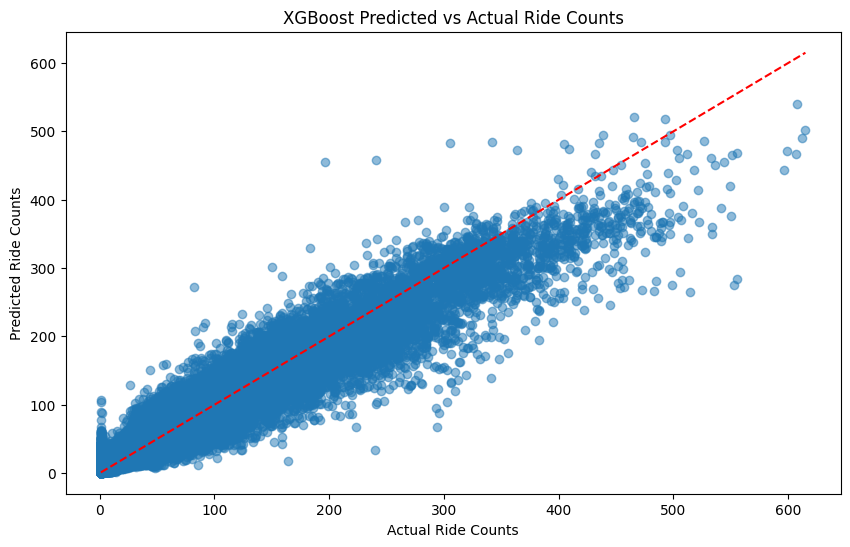

In [9]:
from xgboost import XGBRegressor

# Create an XGBoost regression model


xgb_model = XGBRegressor(objective="count:poisson", random_state=67)
# Fit the model to the training data
xgb_model.fit(train_data, train_labels)
# Predict on the train data
xgb_predictions = xgb_model.predict(train_data)
# Evaluate the model
xgb_mse = mean_squared_error(train_labels, xgb_predictions)
xgb_r2 = r2_score(train_labels, xgb_predictions)
print(f'XGBoost Mean Squared Error: {xgb_mse}')
print(f'XGBoost R^2 Score: {xgb_r2}')
# Visualize the predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(train_labels, xgb_predictions, alpha=0.5)
plt.plot([train_labels.min(), train_labels.max()], [train_labels.min(), train_labels.max()], color='red', linestyle='--')
plt.title('XGBoost Predicted vs Actual Ride Counts')
plt.xlabel('Actual Ride Counts')
plt.ylabel('Predicted Ride Counts')
plt.show()

# Feature Importance 
Zone location, hour of day, and specific day are the top three features that predicts the ride count.

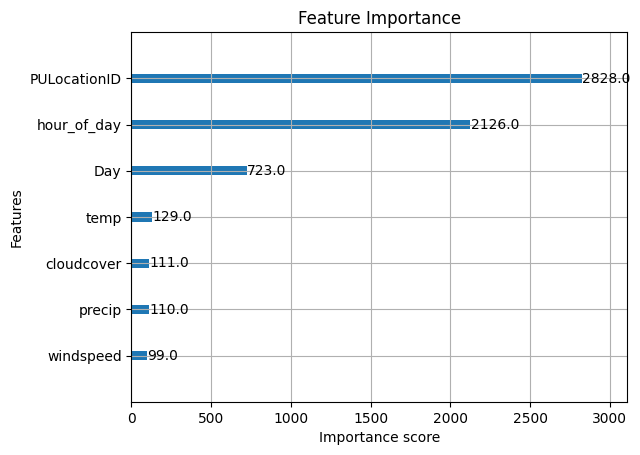

In [10]:
from xgboost import plot_importance
# feature importance
plot_importance(xgb_model)
plt.title('Feature Importance')
plt.show()


# Hypertuning

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}
Tuned XGBoost Mean Squared Error: 194.456005859375
Tuned XGBoost Mean Squared Error: 150.70924377441406
Tuned XGBoost R^2 Score: 0.9681984186172485


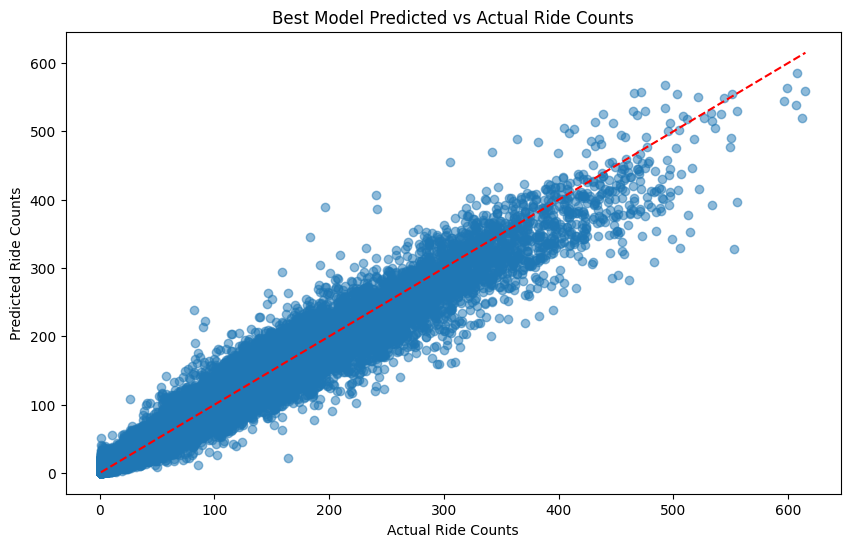

In [16]:
# hyperparameter tuning
from sklearn.model_selection import GridSearchCV
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200], # Number of trees in the ensemble
    'max_depth': [3, 5, 7], # Maximum depth of the trees
    'learning_rate': [0.01, 0.1, 0.2], # Step size shrinkage
    'subsample': [0.8, 1.0], # Fraction of samples to be used for fitting the trees
    'colsample_bytree': [0.8, 1.0] # Fraction of features to be used for fitting the trees
}
# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=-1)
# Fit the model to the training data
grid_search.fit(train_data, train_labels)
# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = -grid_search.best_score_  # Negate the score to get the positive mean squared error

print(f'Best Parameters: {best_params}')
print(f'Tuned XGBoost Mean Squared Error: {best_score}')

# Fit the best model to the training data
best_model = XGBRegressor(**best_params, objective="count:poisson", random_state=67)
best_model.fit(train_data, train_labels)
# Predict on the train data
best_predictions = best_model.predict(train_data)

mse = mean_squared_error(train_labels, best_predictions)
r2 = r2_score(train_labels, best_predictions)

print(f"Tuned XGBoost Mean Squared Error: {mse}")
print(f"Tuned XGBoost R^2 Score: {r2}")

# Visualize the predictions vs actual values for the best model
plt.figure(figsize=(10, 6))
plt.scatter(train_labels, best_predictions, alpha=0.5)
plt.plot([train_labels.min(), train_labels.max()], [train_labels.min(), train_labels.max()], color='red', linestyle='--')
plt.title('Best Model Predicted vs Actual Ride Counts')
plt.xlabel('Actual Ride Counts')
plt.ylabel('Predicted Ride Counts')
plt.show()



# Comparing and Finding best model
Compared both models and XGBoost seems to do have a lower MSE and explain more of the variance of our test data

In [17]:
# Comparing tuned models
models = {
    'Linear Regression': model,
    'Random Forest': rf_model_best,
    'XGBoost': best_model
}
results = {}
for name, mdl in models.items():
    predictions = mdl.predict(test_data)
    mse = mean_squared_error(test_labels, predictions)
    r2 = r2_score(test_labels, predictions)
    results[name] = {'MSE': mse, 'R^2': r2}
results_df = pd.DataFrame(results).T
print(results_df)

                           MSE       R^2
Linear Regression  4446.905992  0.098577
Random Forest       163.734685  0.966810
XGBoost             180.660629  0.963379


# Cross Validation
Cross validate both random forest and XGBoost model to find more consistent model between the two. From the results XGBoost was more consistent compared to random forest.

In [14]:
# cross-validation for the best model
from sklearn.model_selection import cross_val_score
# Perform cross-validation on the best model
cv_scores_xgb = cross_val_score(best_model, x, y, cv=5, scoring='neg_mean_squared_error')
cv_scores_xgb = -cv_scores_xgb  # Negate the scores to get positive mean squared error
print(f'Cross-Validation Mean Squared Error for XGBoost Model: {cv_scores_xgb.mean()}')
# R^2 Score for the best model
print(f'Cross-Validation Standard Deviation for XGBoost Model: {cv_scores_xgb.std()}')  

cv_scores_rf = cross_val_score(rf_model_best, x, y, cv=5, scoring='neg_mean_squared_error')
cv_scores_rf = -cv_scores_rf  # Negate the scores to get positive mean squared error
print(f'Cross-Validation Mean Squared Error for Random Forest: {cv_scores_rf.mean()}')
print(f'Cross-Validation Standard Deviation for Random Forest: {cv_scores_rf.std()}')




Cross-Validation Mean Squared Error for XGBoost Model: 678.6308166503907
Cross-Validation Standard Deviation for XGBoost Model: 407.50303634258574
Cross-Validation Mean Squared Error for Random Forest: 718.7254762092978
Cross-Validation Standard Deviation for Random Forest: 405.05002836438166


In [19]:
# overfitting check for the best model
# Evaluate the best model on the training set
train_best_predictions = best_model.predict(train_data)
train_best_mse = mean_squared_error(train_labels, train_best_predictions)
train_best_r2 = r2_score(train_labels, train_best_predictions)
print(f'Tuned XGBoost Model Training Mean Squared Error: {train_best_mse}')
print(f'Tuned XGBoost Model Training R^2 Score: {train_best_r2}')
# Evaluate the best model on the test set
test_best_predictions = best_model.predict(test_data)
test_best_mse = mean_squared_error(test_labels, test_best_predictions)
test_best_r2 = r2_score(test_labels, test_best_predictions)
print(f'Tuned XGBoost Model Test Mean Squared Error: {test_best_mse}')
print(f'Tuned XGBoost Model Test R^2 Score: {test_best_r2}')

# check for overfitting in the tuned random forest model
train_predictions_rf_best = rf_model_best.predict(train_data)
train_mse_rf_best = mean_squared_error(train_labels, train_predictions_rf_best)
train_r2_rf_best = r2_score(train_labels, train_predictions_rf_best)
print(f'Tuned Random Forest Training Mean Squared Error: {train_mse_rf_best}')
print(f'Tuned Random Forest Training R^2 Score: {train_r2_rf_best}')
test_predictions_rf_best = rf_model_best.predict(test_data)
test_mse_rf_best = mean_squared_error(test_labels, test_predictions_rf_best)
test_r2_rf_best = r2_score(test_labels, test_predictions_rf_best)
print(f'Tuned Random Forest Test Mean Squared Error: {test_mse_rf_best}')
print(f'Tuned Random Forest Test R^2 Score: {test_r2_rf_best}')


Tuned XGBoost Model Training Mean Squared Error: 150.70924377441406
Tuned XGBoost Model Training R^2 Score: 0.9681984186172485
Tuned XGBoost Model Test Mean Squared Error: 180.66062927246094
Tuned XGBoost Model Test R^2 Score: 0.9633786678314209
Tuned Random Forest Training Mean Squared Error: 100.59896116487693
Tuned Random Forest Training R^2 Score: 0.9787723383157371
Tuned Random Forest Test Mean Squared Error: 163.7346851293569
Tuned Random Forest Test R^2 Score: 0.966809669647946


# ML deployment


In [ ]:
# save best model
import joblib
# Save the best XGBoost model to make a web app
joblib.dump(best_model, 'best_xgboost_model.pkl')


['best_xgboost_model.pkl']